https://youtu.be/WCo1fchV4R8

# 3D Organoid Segmentation & Feature Extraction
**Created by:** Dr. Sreenivas Bhattiprolu ([@DigitalSreeni](https://www.youtube.com/c/DigitalSreeni))

## Introduction

This notebook walks you through the process of segmenting cells and nuclei within an organoid collected from a fluorescence microscope, then extracting features - all using Python code.

### Dataset

The organoid dataset can be downloaded from here:  
**https://github.com/quantacell/3DcellScope/tree/main/images**

Specifically, you'll need:
- **PDAC-C1.tif** - Nuclei channel (DAPI)
- **PDAC-C2.tif** - Cytoplasm channel

### Approach

The approach is straightforward: use the well-established **Cellpose** algorithm to perform 3D segmentation of cells and nuclei. However, it requires a methodical approach to ensure good results.

**Step-by-step workflow:**  
2D validation → 3D segmentation → Quality control → Feature extraction

### Detailed Workflow

1. **Load separate channel files** - Import nuclei and cytoplasm images
2. **Inspect and visualize raw data** - Check image quality and intensity distributions
3. **Normalize images** - Enhance contrast for better segmentation
4. **Test segmentation on 2D slices** - Validate parameters before running full 3D
5. **Optimize parameters** - Adjust thresholds for your specific data
6. **Run 3D segmentation** - Process entire z-stack (takes 10-20 minutes)
7. **Quality control** - Filter out small cells and cells without nuclei
8. **Extract metrics** - Calculate morphological, intensity, and spatial features

### Note on Commercial Alternatives

**PS:** While this is a Python-based approach, please note that commercial software like **ZEISS arivis** provides a non-coding and interactive way to perform this task easily. This notebook is ideal for those who want:
- Full control over the analysis pipeline
- Reproducible, scriptable workflows
- No licensing costs
- Ability to customize and extend the analysis

---

## Install and Import

Colab comes preloaded with many libraries but not cellpose.

In [ ]:
# Install packages (run once)
!pip install cellpose -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 89.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from cellpose import models
import torch
from skimage import measure
from scipy import ndimage
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✓ All packages imported successfully")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

✓ All packages imported successfully
✓ CUDA available: True
✓ GPU: Tesla T4


## Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==================== FILE PATHS ====================
DATA_DIR = "/content/drive/MyDrive/ColabNotebooks/data/3D_Organoid_Analysis/images/"
NUCLEI_FILE = DATA_DIR + "PDAC-C1.tif"  # DAPI/Nuclei channel
CELLS_FILE = DATA_DIR + "PDAC-C2.tif"   # Cytoplasm/Cells channel
OUTPUT_DIR = DATA_DIR + "segmentation_output/"  # Saves to Google Drive!

# ==================== MICROSCOPE PARAMETERS ====================
PIXEL_SIZE_XY = 0.345  # microns per pixel in XY
PIXEL_SIZE_Z = 1.0     # microns per z-slice
ANISOTROPY = PIXEL_SIZE_Z / PIXEL_SIZE_XY

# ==================== VISUALIZATION ====================
#For later use...
SLICE_TO_VIEW = None  # None = middle slice, or specify slice number (e.g., 50)


print("✓ Configuration loaded")
print(f"  Anisotropy: {ANISOTROPY:.2f}")


✓ Configuration loaded
  Anisotropy: 2.90


## Load Images

In case you work with multi-channel images and want to use this code without any changes, you need to separate nuclei and cell channels first.

In [ ]:
print("="*60)
print("LOADING IMAGES")
print("="*60)

# Load nuclei channel
print(f"\nLoading: {NUCLEI_FILE}")
nuclei = tiff.imread(NUCLEI_FILE)
print(f"✓ Nuclei loaded")
print(f"  Shape: {nuclei.shape}")
print(f"  Data type: {nuclei.dtype}")
print(f"  Bit depth: {nuclei.dtype.itemsize * 8}-bit")
print(f"  Min value: {nuclei.min()}")
print(f"  Max value: {nuclei.max()}")
print(f"  Mean value: {nuclei.mean():.1f}")

# Load cells channel
print(f"\nLoading: {CELLS_FILE}")
cells = tiff.imread(CELLS_FILE)
print(f"✓ Cells loaded")
print(f"  Shape: {cells.shape}")
print(f"  Data type: {cells.dtype}")
print(f"  Bit depth: {cells.dtype.itemsize * 8}-bit")
print(f"  Min value: {cells.min()}")
print(f"  Max value: {cells.max()}")
print(f"  Mean value: {cells.mean():.1f}")

# Get dimensions
Z, Y, X = nuclei.shape
print(f"\n✓ Image dimensions: {Z} slices × {Y} × {X} pixels")
print(f"  Physical size: {Z*PIXEL_SIZE_Z:.1f} × {Y*PIXEL_SIZE_XY:.1f} × {X*PIXEL_SIZE_XY:.1f} μm")

# Determine which slice to view
if SLICE_TO_VIEW is None:
    view_slice = Z // 2
    print(f"\n✓ Using middle slice: {view_slice}")
else:
    view_slice = SLICE_TO_VIEW
    print(f"\n✓ Using specified slice: {view_slice}")

LOADING IMAGES

Loading: /content/drive/MyDrive/ColabNotebooks/data/3D_Organoid_Analysis/images/PDAC-C1.tif
✓ Nuclei loaded
  Shape: (109, 512, 512)
  Data type: uint16
  Bit depth: 16-bit
  Min value: 0
  Max value: 2112
  Mean value: 157.7

Loading: /content/drive/MyDrive/ColabNotebooks/data/3D_Organoid_Analysis/images/PDAC-C2.tif
✓ Cells loaded
  Shape: (109, 512, 512)
  Data type: uint16
  Bit depth: 16-bit
  Min value: 0
  Max value: 4095
  Mean value: 256.0

✓ Image dimensions: 109 slices × 512 × 512 pixels
  Physical size: 109.0 × 176.6 × 176.6 μm

✓ Using middle slice: 54


## Visualize Raw Data

### Understanding Image Properties

The loaded images are typically **16-bit** (values 0-65535), but microscopes rarely use the full range. Notice how the maximum values are well below 65535. This is why normalization is critical - it will rescale the actual used range to 0-1 for optimal segmentation.

**Key metrics to check:**
- **Shape**: Verify dimensions match (Z, Y, X)
- **Data type**: Usually uint16 for fluorescence microscopy
- **Value range**: Actual min/max tells us how much of the bit depth is used
- **Mean**: Gives a sense of overall brightness

The histograms below will show that most intensity information is concentrated in a narrow range, wasting most of the available bit depth.

VISUALIZING RAW DATA


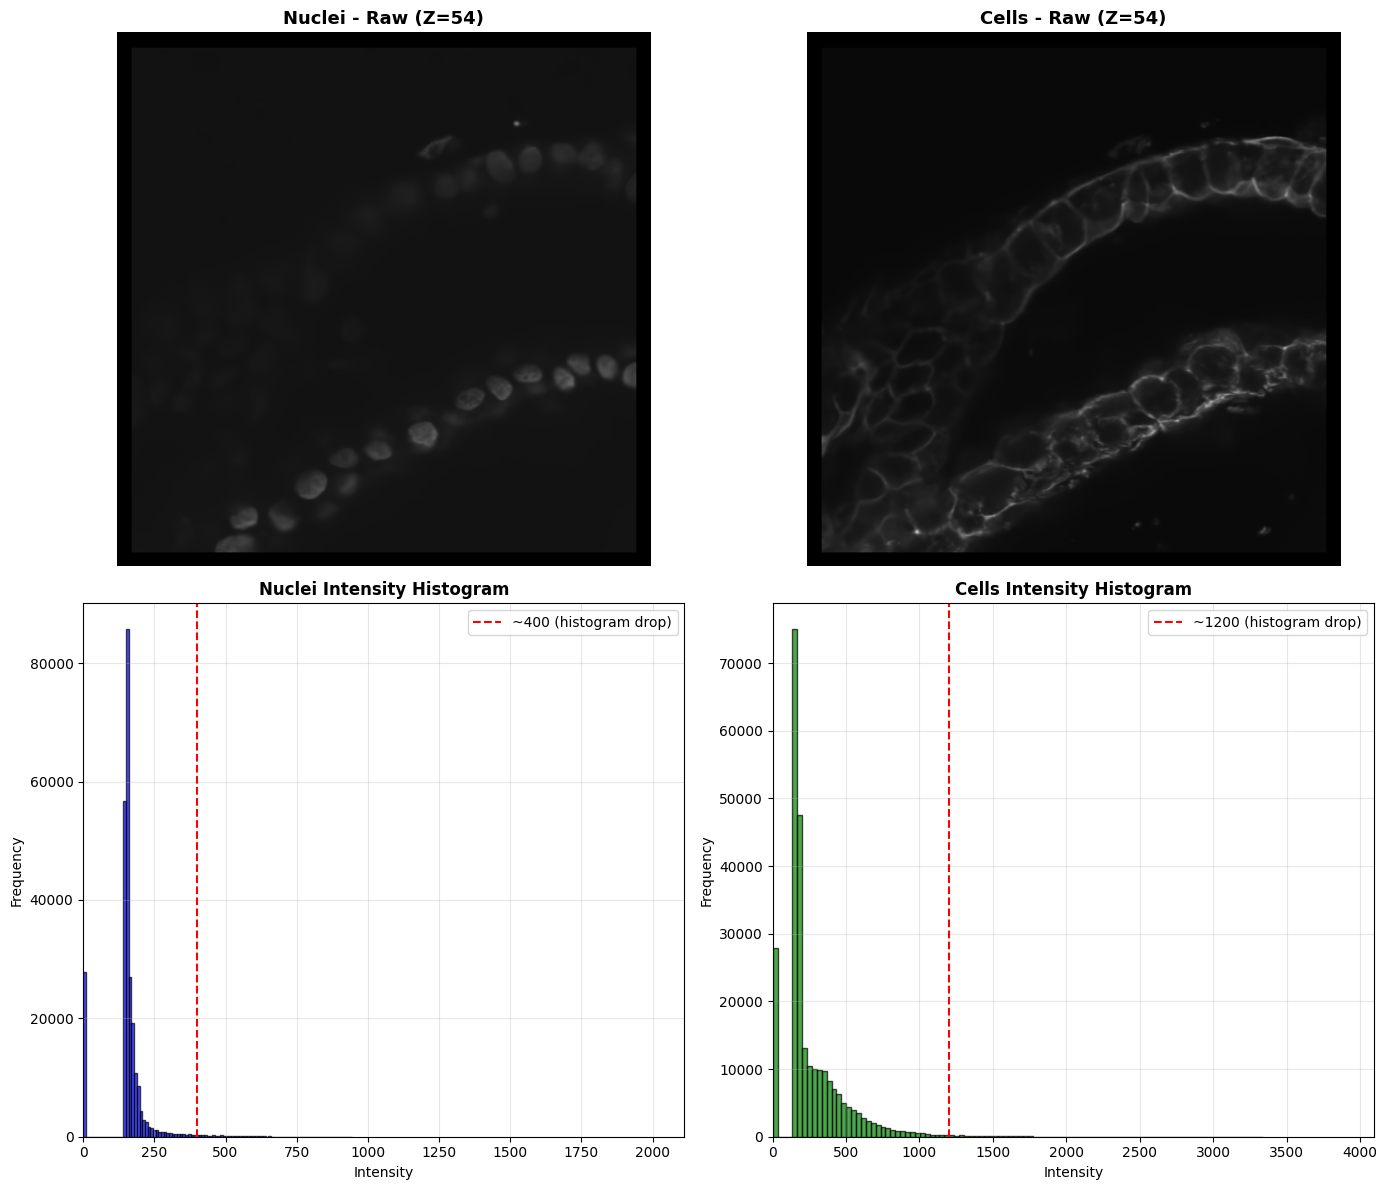


✓ Observation: Images are 16-bit but most information is in lower range
  → Normalization will help improve contrast for segmentation


In [ ]:
print("="*60)
print("VISUALIZING RAW DATA")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Nuclei raw
axes[0, 0].imshow(nuclei[view_slice], cmap='gray', vmin=0, vmax=nuclei.max())
axes[0, 0].set_title(f'Nuclei - Raw (Z={view_slice})', fontsize=13, fontweight='bold')
axes[0, 0].axis('off')

# Cells raw
axes[0, 1].imshow(cells[view_slice], cmap='gray', vmin=0, vmax=cells.max())
axes[0, 1].set_title(f'Cells - Raw (Z={view_slice})', fontsize=13, fontweight='bold')
axes[0, 1].axis('off')

# Nuclei histogram
axes[1, 0].hist(nuclei[view_slice].flatten(), bins=100, color='blue', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Nuclei Intensity Histogram', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Intensity')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(0, nuclei.max())
axes[1, 0].axvline(400, color='red', linestyle='--', label='~400 (histogram drop)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Cells histogram
axes[1, 1].hist(cells[view_slice].flatten(), bins=100, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Cells Intensity Histogram', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Intensity')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlim(0, cells.max())
axes[1, 1].axvline(1200, color='red', linestyle='--', label='~1200 (histogram drop)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Observation: Images are 16-bit but most information is in lower range")
print("  → Normalization will help improve contrast for segmentation")

## Normalize Images



### Why Normalize?

**Problem**: 16-bit images have a theoretical range of 0-65535, but actual signal typically spans only a few hundred to a few thousand intensity units. This leaves most of the dynamic range unused.

**Solution**: Percentile-based normalization
1. Finds the 1st and 99th percentile of intensity values
2. Clips extreme outliers (very bright/dark pixels)
3. Rescales the clipped range to 0-1

**Benefits**:
- Enhances contrast for dim features
- Reduces impact of bright artifacts or hot pixels
- Standardizes input for Cellpose (which expects 0-1 range)
- Works consistently across different microscopes and exposure settings

**Alternative**: You could use the actual min/max, but this is sensitive to outliers. Percentiles are more robust.

In [ ]:
print("="*60)
print("NORMALIZING IMAGES")
print("="*60)

def normalize_image(img, lower_percentile=1, upper_percentile=99):
    """
    Normalize image to 0-1 range using percentile clipping.
    This helps with 16-bit images where most info is in lower values.
    """
    p_low = np.percentile(img, lower_percentile)
    p_high = np.percentile(img, upper_percentile)

    print(f"  Percentile range: {p_low:.1f} - {p_high:.1f}")

    img_norm = np.clip(img, p_low, p_high)
    img_norm = (img_norm - p_low) / (p_high - p_low + 1e-8)

    return img_norm

print("\nNormalizing nuclei...")
nuclei_norm = normalize_image(nuclei)
print(f"✓ Nuclei normalized: [{nuclei_norm.min():.3f}, {nuclei_norm.max():.3f}]")

print("\nNormalizing cells...")
cells_norm = normalize_image(cells)
print(f"✓ Cells normalized: [{cells_norm.min():.3f}, {cells_norm.max():.3f}]")

NORMALIZING IMAGES

Normalizing nuclei...
  Percentile range: 0.0 - 553.0
✓ Nuclei normalized: [0.000, 1.000]

Normalizing cells...
  Percentile range: 0.0 - 1405.0
✓ Cells normalized: [0.000, 1.000]


## Visualize Normalized Data

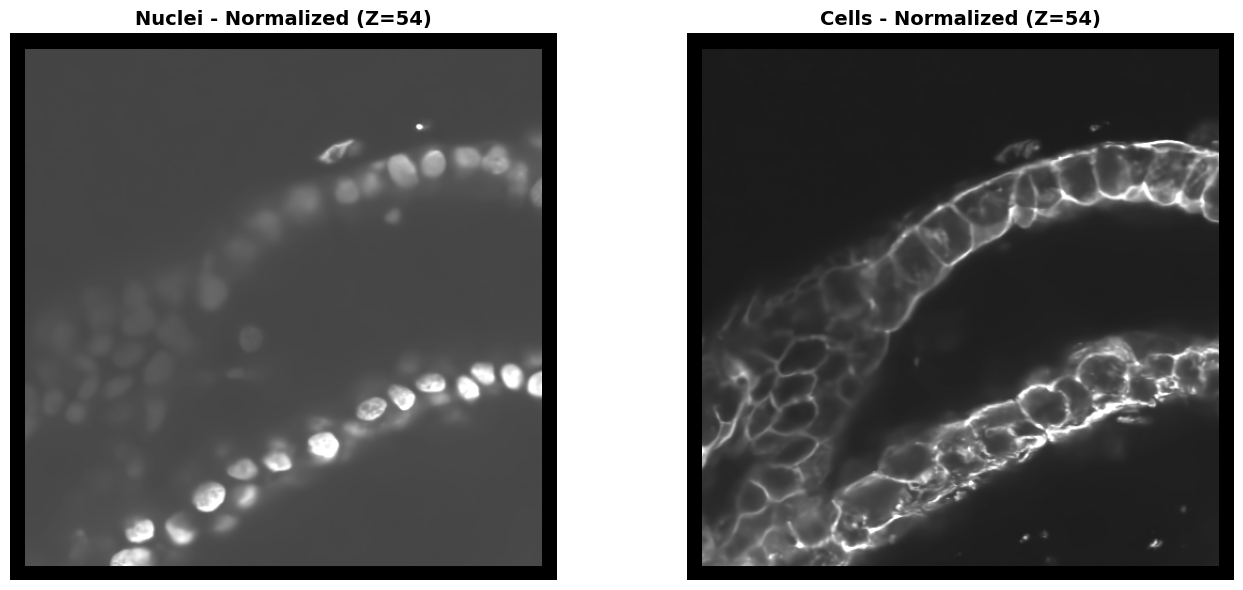

✓ Normalized images show better contrast


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(nuclei_norm[view_slice], cmap='gray')
axes[0].set_title(f'Nuclei - Normalized (Z={view_slice})', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(cells_norm[view_slice], cmap='gray')
axes[1].set_title(f'Cells - Normalized (Z={view_slice})', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✓ Normalized images show better contrast")

## Initialize Cellpose Models for 2D Testing



### Why Test in 2D First?

**Time savings**: 3D segmentation takes 10-20 minutes. Testing on single slices takes seconds.

**Parameter tuning**: The key parameters (`diameter`, `flow_threshold`) have the same effect in 2D and 3D, so you can optimize them quickly in 2D before committing to the full 3D run.

**What to look for**:
- **Under-segmentation**: Multiple cells merged together → Increase `flow_threshold` or decrease `diameter`
- **Over-segmentation**: Single cells split into pieces → Decrease `flow_threshold` or increase `diameter`
- **Nucleus-cell alignment**: Each cell should contain one nucleus



In [ ]:
print("="*60)
print("INITIALIZING CELLPOSE MODELS (2D MODE)")
print("="*60)

use_gpu = torch.cuda.is_available()
print(f"\nUsing GPU: {use_gpu}")


INITIALIZING CELLPOSE MODELS (2D MODE)

Using GPU: True


## Test Segmentation on 2D Slice - NUCLEI

Adjust parameters here until segmentation looks good! It took a couple of iterations for me to find the optimal diameter and flow thresholds.

In [ ]:
# ==================== NUCLEI SEGMENTATION PARAMETERS ====================
NUCLEI_DIAMETER = 30      # pixels - adjust based on your nuclei
NUCLEI_FLOW_THRESHOLD = 0.4    # 0.0-1.0, lower = more conservative
NUCLEI_CELLPROB_THRESHOLD = 0.0  # -6 to 6, higher = more stringent


print(f"\n  NUCLEI parameters:")
print(f"    Diameter: {NUCLEI_DIAMETER} pixels")
print(f"    Flow threshold: {NUCLEI_FLOW_THRESHOLD}")
print(f"    Cellprob threshold: {NUCLEI_CELLPROB_THRESHOLD}")

#Initialize model
nuclei_model_2d = models.CellposeModel(gpu=use_gpu, model_type='nuclei')
print("✓ Nuclei model loaded: nuclei")


  NUCLEI parameters:
    Diameter: 30 pixels
    Flow threshold: 0.4
    Cellprob threshold: 0.0


100%|██████████| 1.15G/1.15G [00:13<00:00, 93.5MB/s]


✓ Nuclei model loaded: nuclei


2D NUCLEI SEGMENTATION TEST

Segmenting slice 54...
  Parameters:
    Diameter: 30 pixels
    Flow threshold: 0.4
    Cellprob threshold: 0.0

✓ Detected 46 nuclei in slice 54


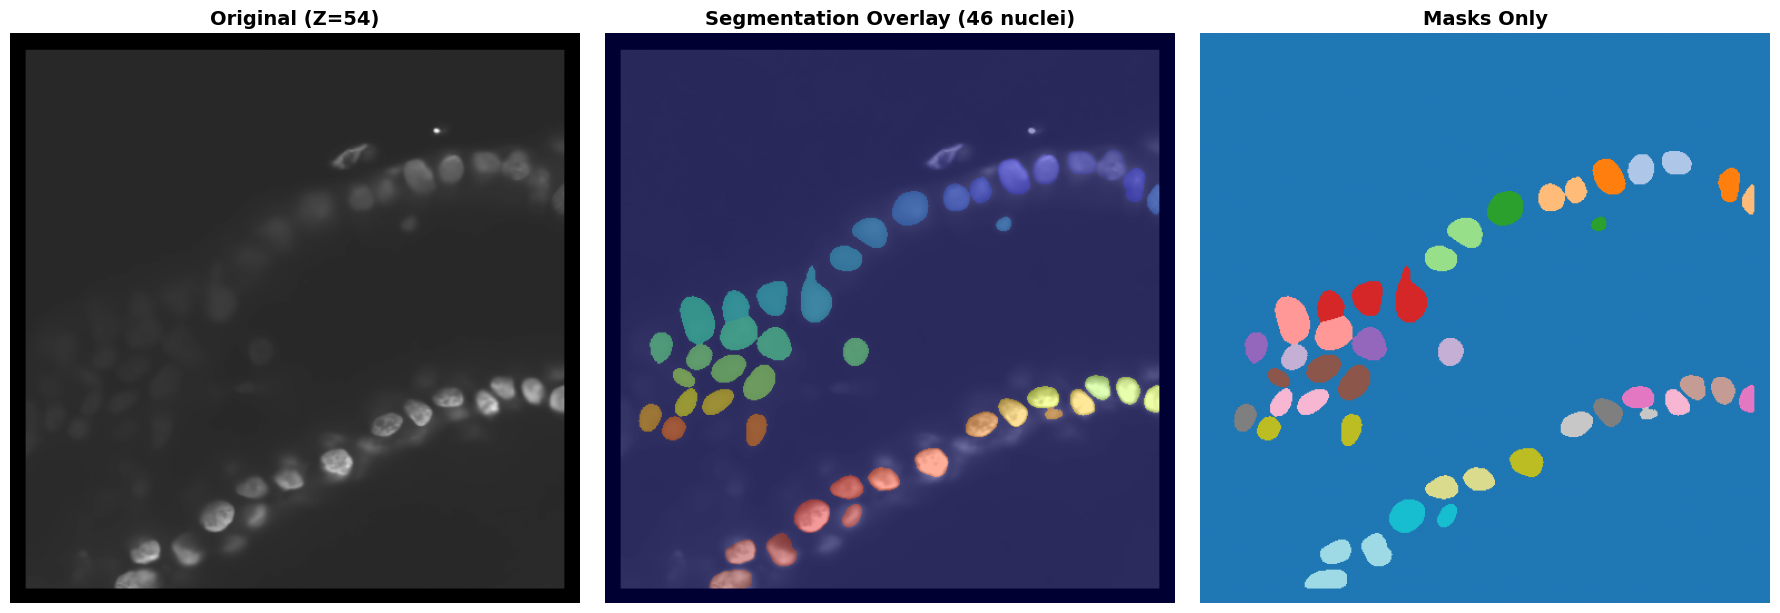


💡 TIP: Adjust NUCLEI_DIAMETER, FLOW_THRESHOLD, CELLPROB_THRESHOLD above
   if segmentation doesn't look good, then re-run this cell


In [ ]:
print("="*60)
print("2D NUCLEI SEGMENTATION TEST")
print("="*60)

print(f"\nSegmenting slice {view_slice}...")
print(f"  Parameters:")
print(f"    Diameter: {NUCLEI_DIAMETER} pixels")
print(f"    Flow threshold: {NUCLEI_FLOW_THRESHOLD}")
print(f"    Cellprob threshold: {NUCLEI_CELLPROB_THRESHOLD}")

# Segment single slice in 2D
nuclei_masks_2d, nuclei_flows_2d = nuclei_model_2d.eval(
    nuclei_norm[view_slice],
    diameter=NUCLEI_DIAMETER,
    channels=[0, 0],
    do_3D=False,  # 2D mode
    flow_threshold=NUCLEI_FLOW_THRESHOLD,
    cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
)[:2]

num_nuclei_2d = nuclei_masks_2d.max()
print(f"\n✓ Detected {num_nuclei_2d} nuclei in slice {view_slice}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(nuclei[view_slice], cmap='gray')
axes[0].set_title(f'Original (Z={view_slice})', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(nuclei_norm[view_slice], cmap='gray')
axes[1].imshow(nuclei_masks_2d, alpha=0.4, cmap='jet')
axes[1].set_title(f'Segmentation Overlay ({num_nuclei_2d} nuclei)', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(nuclei_masks_2d, cmap='tab20')
axes[2].set_title('Masks Only', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 TIP: Adjust NUCLEI_DIAMETER, FLOW_THRESHOLD, CELLPROB_THRESHOLD above")
print("   if segmentation doesn't look good, then re-run this cell")

## Test Segmentation on 2D Slice - CELLS
### Adjust parameters here until segmentation looks good! Just like we did for nuclei segmentation

In [ ]:
# ==================== CELL SEGMENTATION PARAMETERS ====================
CELL_DIAMETER = 50        # pixels - adjust based on your cells
CELL_FLOW_THRESHOLD = 0.6      # 0.0-1.0, HIGHER = more separation (try 0.6-0.8)
CELL_CELLPROB_THRESHOLD = 0  # -6 to 6, higher = more stringent

print(f"\n  CELL parameters:")
print(f"    Diameter: {CELL_DIAMETER} pixels")
print(f"    Flow threshold: {CELL_FLOW_THRESHOLD}")
print(f"    Cellprob threshold: {CELL_CELLPROB_THRESHOLD}")

# Initialize models
print("\nLoading models...")
cell_model_2d = models.CellposeModel(gpu=use_gpu, model_type='cyto3')
print("✓ Cell model loaded: cyto3")





  CELL parameters:
    Diameter: 50 pixels
    Flow threshold: 0.6
    Cellprob threshold: 0

Loading models...
✓ Cell model loaded: cyto3


### Two-Channel Input Explained

**Standard approach**: Segment cytoplasm channel only

**Better approach** (used here): Provide both cytoplasm AND nuclei channels to the cell segmentation model

**Why it works**: The Cellpose `cyto3` model was trained on images with both channels. The nuclei signal helps the model identify where one cell ends and another begins, especially for densely packed or touching cells.

**Implementation**: Stack the two channels into a single 4D array, then tell Cellpose:
- `channels=[1, 2]` means "channel 1 is what to segment (cytoplasm), channel 2 is a guide (nuclei)"

2D CELL SEGMENTATION TEST

Segmenting slice 54...
  Parameters:
    Diameter: 50 pixels
    Flow threshold: 0.6
    Cellprob threshold: 0

✓ Detected 51 cells in slice 54


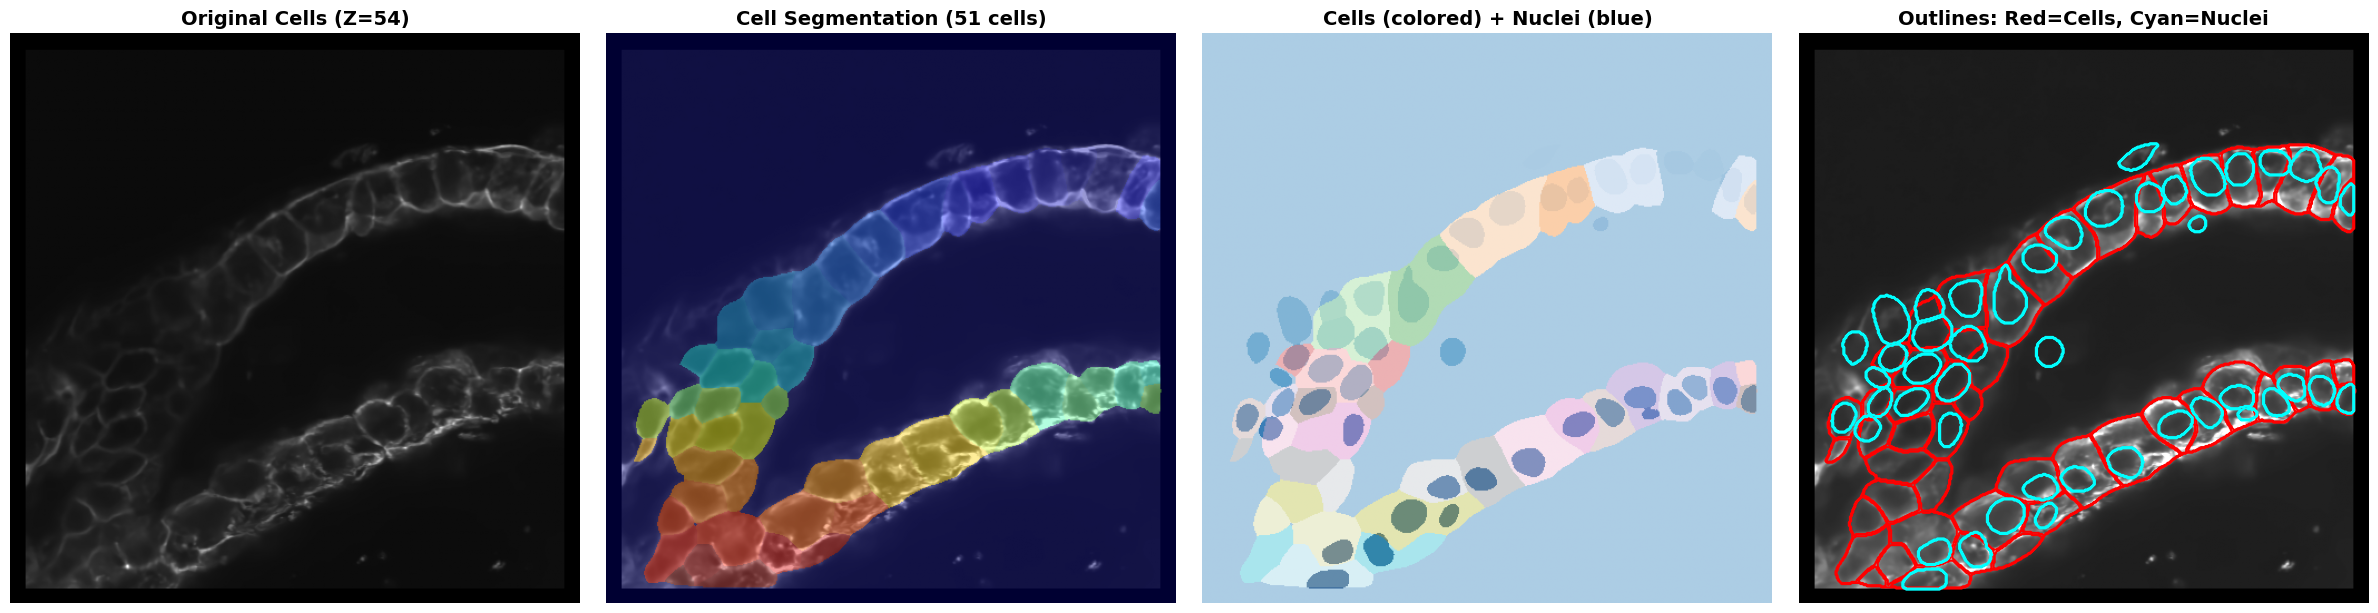


💡 Check if nuclei align well with cell boundaries:
   - Each cell should contain one nucleus
   - Cell boundaries should separate nuclei properly

💡 TIP: Adjust CELL_DIAMETER, FLOW_THRESHOLD, CELLPROB_THRESHOLD above
   if segmentation doesn't look good, then re-run this cell


In [ ]:
print("="*60)
print("2D CELL SEGMENTATION TEST")
print("="*60)

print(f"\nSegmenting slice {view_slice}...")
print(f"  Parameters:")
print(f"    Diameter: {CELL_DIAMETER} pixels")
print(f"    Flow threshold: {CELL_FLOW_THRESHOLD}")
print(f"    Cellprob threshold: {CELL_CELLPROB_THRESHOLD}")

# Segment single slice in 2D
# Create 2-channel input: [cells, nuclei]
img_2channel = np.stack([cells_norm[view_slice], nuclei_norm[view_slice]], axis=-1)

cell_masks_2d, cell_flows_2d = cell_model_2d.eval(
    img_2channel,
    diameter=CELL_DIAMETER,
    channels=[1, 2],  # 1=grayscale cells (channel 0), 2=grayscale nuclei (channel 1)
    do_3D=False,  # 2D mode
    flow_threshold=CELL_FLOW_THRESHOLD,
    cellprob_threshold=CELL_CELLPROB_THRESHOLD,
)[:2]

num_cells_2d = cell_masks_2d.max()
print(f"\n✓ Detected {num_cells_2d} cells in slice {view_slice}")

# Visualize with nuclei overlay
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Original
axes[0].imshow(cells[view_slice], cmap='gray')
axes[0].set_title(f'Original Cells (Z={view_slice})', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Cell segmentation overlay
axes[1].imshow(cells_norm[view_slice], cmap='gray')
axes[1].imshow(cell_masks_2d, alpha=0.4, cmap='jet')
axes[1].set_title(f'Cell Segmentation ({num_cells_2d} cells)', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Cell masks + nuclei segmentation overlay
axes[2].imshow(cell_masks_2d, cmap='tab20', alpha=0.7)
axes[2].imshow(nuclei_masks_2d, alpha=0.5, cmap='Blues')
axes[2].set_title(f'Cells (colored) + Nuclei (blue)', fontsize=14, fontweight='bold')
axes[2].axis('off')

# Cell outlines + nuclei outlines
from skimage import segmentation
cell_outlines = segmentation.find_boundaries(cell_masks_2d, mode='outer')
nuclei_outlines = segmentation.find_boundaries(nuclei_masks_2d, mode='outer')

axes[3].imshow(cells_norm[view_slice], cmap='gray')
axes[3].contour(cell_outlines, colors='red', linewidths=1.5, levels=[0.5])
axes[3].contour(nuclei_outlines, colors='cyan', linewidths=1.5, levels=[0.5])
axes[3].set_title('Outlines: Red=Cells, Cyan=Nuclei', fontsize=14, fontweight='bold')
axes[3].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Check if nuclei align well with cell boundaries:")
print("   - Each cell should contain one nucleus")
print("   - Cell boundaries should separate nuclei properly")
print("\n💡 TIP: Adjust CELL_DIAMETER, FLOW_THRESHOLD, CELLPROB_THRESHOLD above")
print("   if segmentation doesn't look good, then re-run this cell")

## Test on Multiple Slices (Optional, but gives peace of mind)
### Verify parameters work across different Z positions

TESTING ON MULTIPLE SLICES

Testing slice 27...


  Z=27: 54 nuclei, 59 cells

Testing slice 54...


  Z=54: 46 nuclei, 48 cells

Testing slice 81...


  Z=81: 18 nuclei, 43 cells


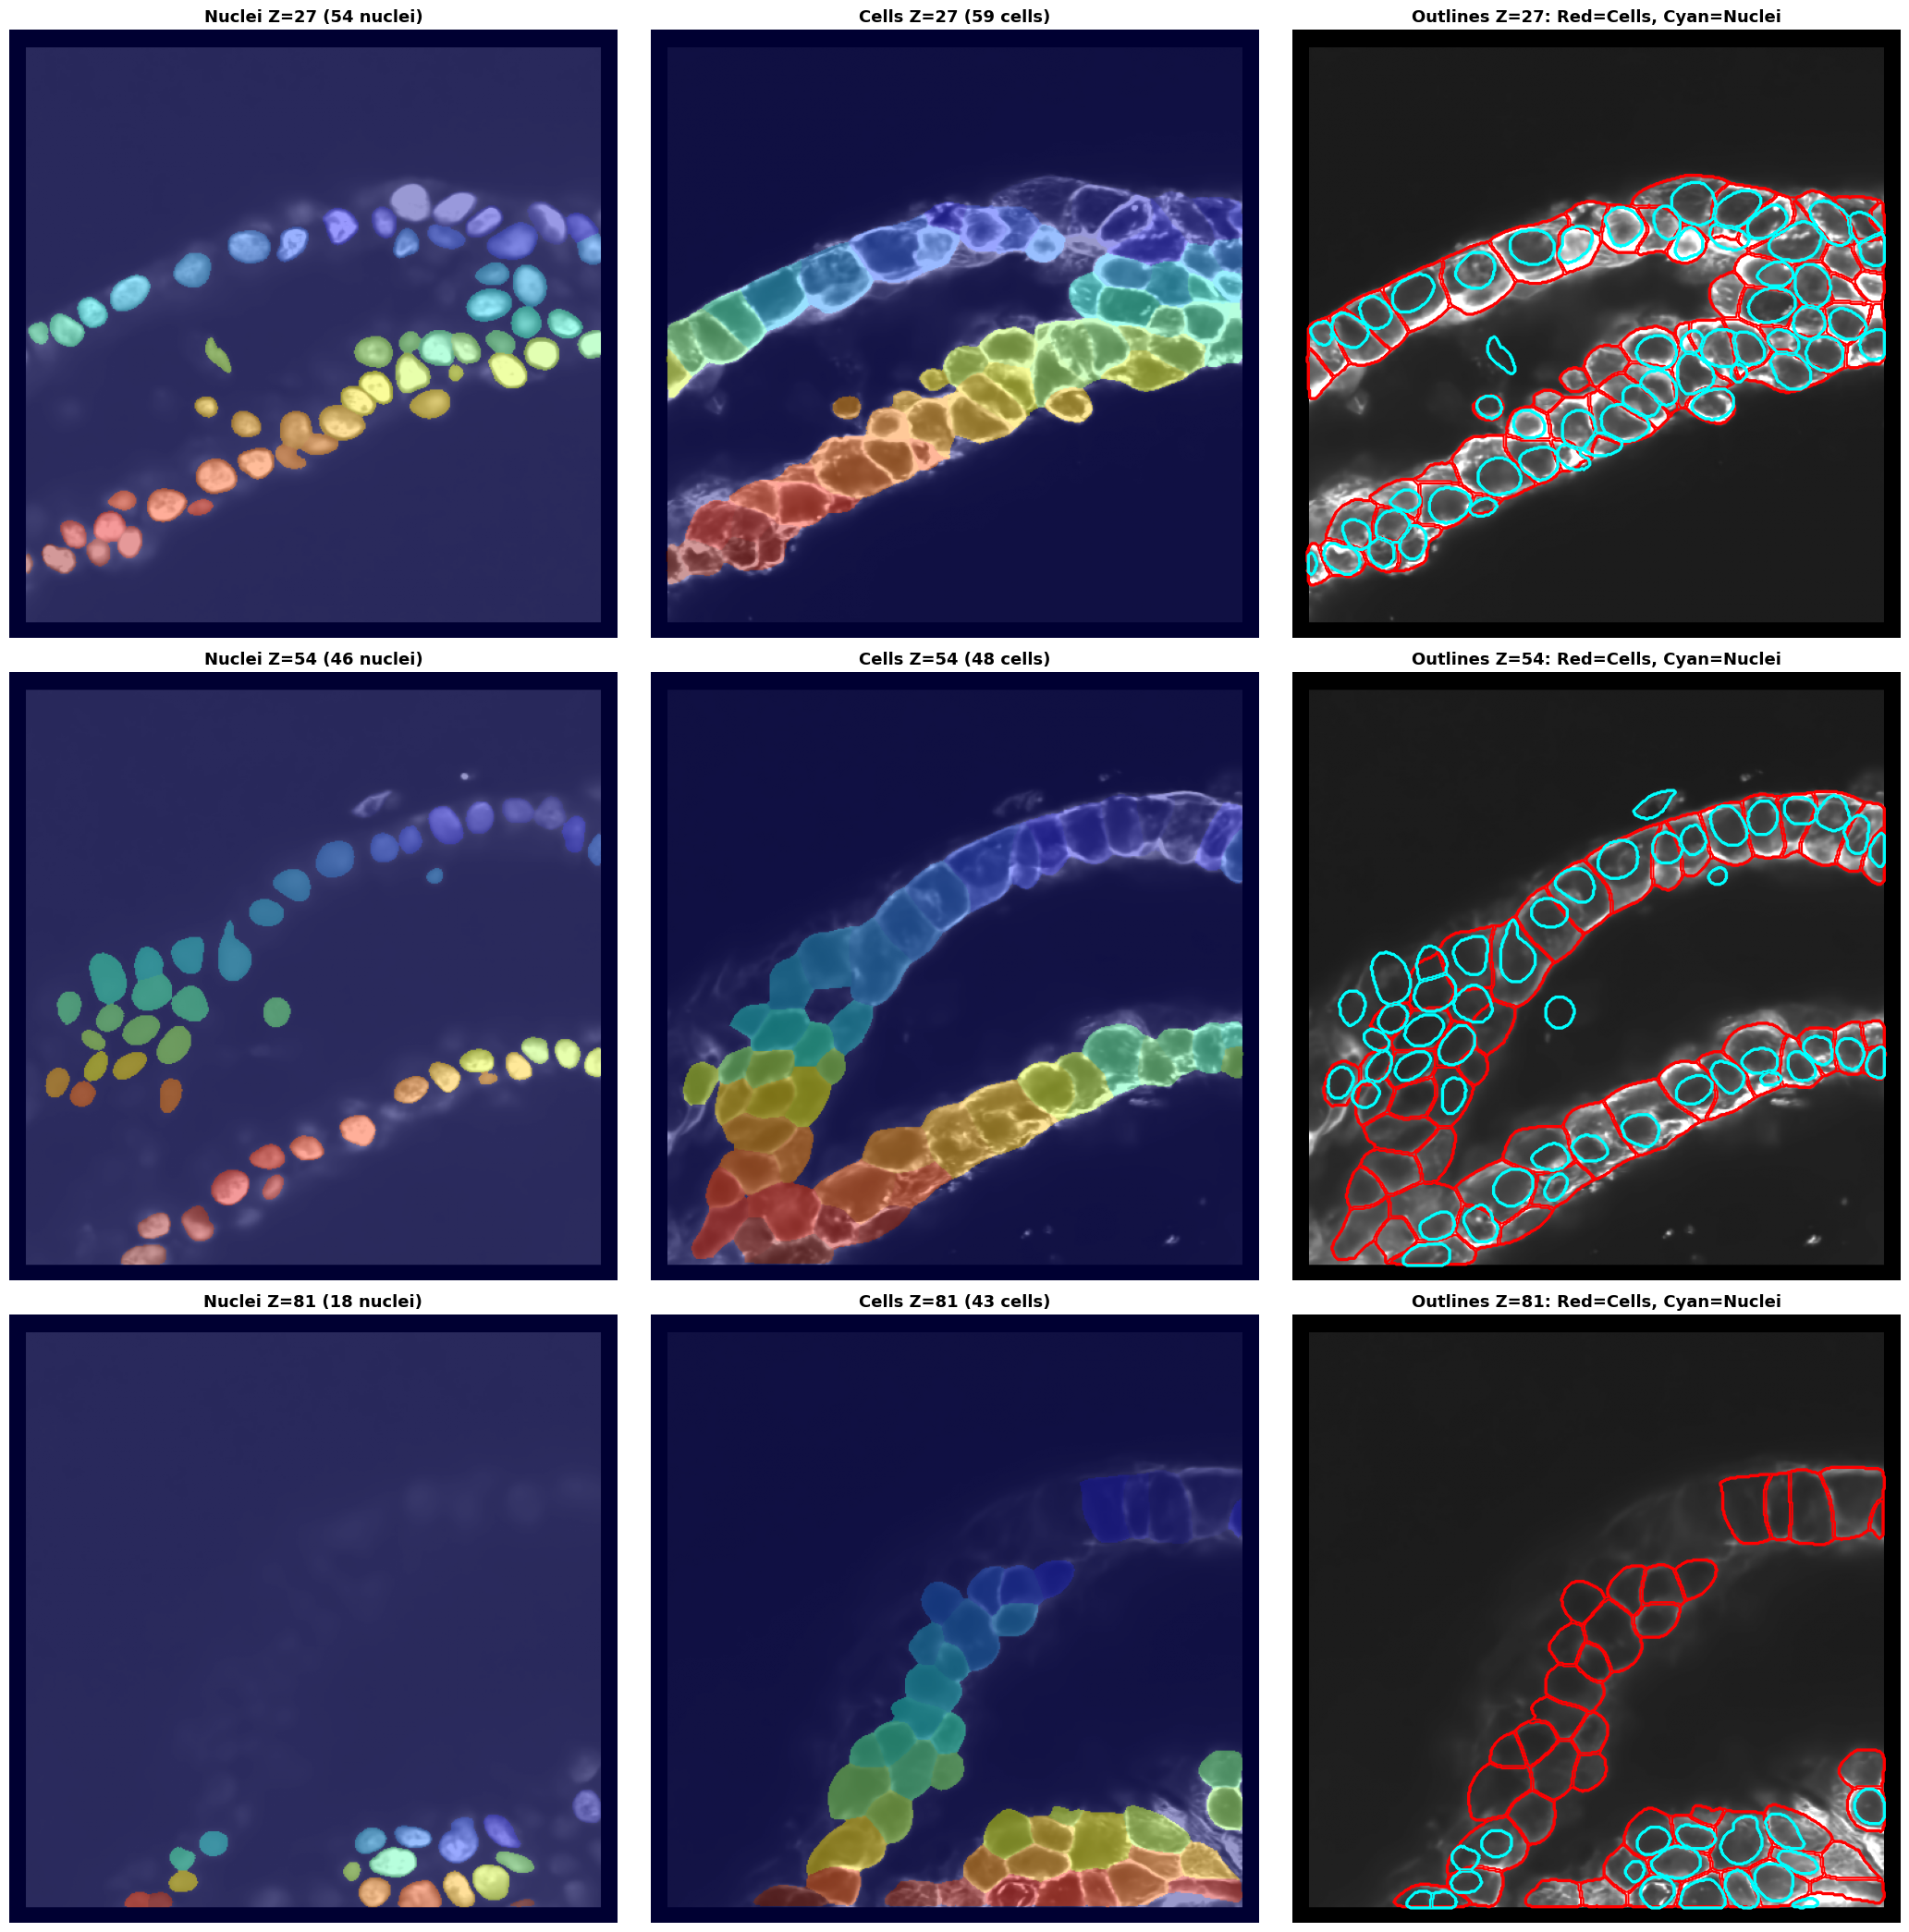


✓ If segmentation looks good across slices, proceed to 3D!


In [ ]:
print("="*60)
print("TESTING ON MULTIPLE SLICES")
print("="*60)

from skimage import segmentation

# Test on 3 slices: beginning, middle, end
test_slices = [Z//4, Z//2, 3*Z//4]

fig, axes = plt.subplots(len(test_slices), 3, figsize=(21, 7*len(test_slices)))

for i, z in enumerate(test_slices):
    print(f"\nTesting slice {z}...")

    # Segment nuclei
    n_mask, _ = nuclei_model_2d.eval(
        nuclei_norm[z], diameter=NUCLEI_DIAMETER, channels=[0,0], do_3D=False
    )[:2]

    # Segment cells
    # Create 2-channel input
    img_2ch = np.stack([cells_norm[z], nuclei_norm[z]], axis=-1)
    c_mask, _ = cell_model_2d.eval(
            img_2ch, diameter=CELL_DIAMETER, channels=[1,2], do_3D=False
    )[:2]

    # Get outlines
    cell_outlines = segmentation.find_boundaries(c_mask, mode='outer')
    nuclei_outlines = segmentation.find_boundaries(n_mask, mode='outer')

    # Plot 1: Nuclei overlay
    axes[i, 0].imshow(nuclei_norm[z], cmap='gray')
    axes[i, 0].imshow(n_mask, alpha=0.4, cmap='jet')
    axes[i, 0].set_title(f'Nuclei Z={z} ({n_mask.max()} nuclei)', fontsize=13, fontweight='bold')
    axes[i, 0].axis('off')

    # Plot 2: Cells overlay
    axes[i, 1].imshow(cells_norm[z], cmap='gray')
    axes[i, 1].imshow(c_mask, alpha=0.4, cmap='jet')
    axes[i, 1].set_title(f'Cells Z={z} ({c_mask.max()} cells)', fontsize=13, fontweight='bold')
    axes[i, 1].axis('off')

    # Plot 3: Outlines - Red cells, Cyan nuclei
    axes[i, 2].imshow(cells_norm[z], cmap='gray')
    axes[i, 2].contour(cell_outlines, colors='red', linewidths=1.5, levels=[0.5])
    axes[i, 2].contour(nuclei_outlines, colors='cyan', linewidths=1.5, levels=[0.5])
    axes[i, 2].set_title(f'Outlines Z={z}: Red=Cells, Cyan=Nuclei', fontsize=13, fontweight='bold')
    axes[i, 2].axis('off')

    print(f"  Z={z}: {n_mask.max()} nuclei, {c_mask.max()} cells")

plt.tight_layout()
plt.show()

print("\n✓ If segmentation looks good across slices, proceed to 3D!")

## Initialize Models for 3D Segmentation
### **Once satisfied with 2D results, run full 3D segmentation**

### Why 3D is Better Than 2D

**2D limitations**:
- Cells spanning multiple slices appear as disconnected fragments
- Can't measure true 3D volume, shape, or spatial relationships
- Ambiguous boundaries when cells touch in one slice but not others

**3D advantages**:
- Uses context from neighboring slices for better boundary detection
- Correctly tracks cells across the entire z-stack
- Accurate volume measurements (not just area)
- Better separation of touching cells
- Proper 3D shape characterization

**Trade-off**: Takes longer (20-30 minutes vs seconds, for each), but results are worth it.

**Anisotropy parameter**: Corrects for different spacing in Z vs XY. If your Z-spacing is 3× larger than XY, anisotropy=3.0 tells Cellpose to account for this when determining 3D cell shapes.

In [ ]:
print("="*60)
print("INITIALIZING CELLPOSE MODELS (3D MODE)")
print("="*60)

print(f"\nUsing GPU: {use_gpu}")
print(f"Anisotropy: {ANISOTROPY:.2f}")

# Re-initialize models (fresh start for 3D)
print("\nLoading models...")
cell_model_3d = models.CellposeModel(gpu=use_gpu, model_type='cyto3')
print("✓ Cell model loaded: cyto3")

nuclei_model_3d = models.CellposeModel(gpu=use_gpu, model_type='nuclei')
print("✓ Nuclei model loaded: nuclei")

print("\n✓ Models ready for 3D segmentation")
print("\n⚠️  WARNING: 3D segmentation may take >20 minutes, each!")

INITIALIZING CELLPOSE MODELS (3D MODE)

Using GPU: True
Anisotropy: 3.08

Loading models...


✓ Cell model loaded: cyto3
✓ Nuclei model loaded: nuclei

✓ Models ready for 3D segmentation

⚠️  WARNING: 3D segmentation may take >20 minutes, each!


## 3D Segmentation - NUCLEI

In [ ]:
print("="*60)
print("3D NUCLEI SEGMENTATION")
print("="*60)

print(f"\nSegmenting {Z} slices...")
print(f"  Diameter: {NUCLEI_DIAMETER} pixels")
print(f"  Anisotropy: {ANISOTROPY:.2f}")
print(f"  Flow threshold: {NUCLEI_FLOW_THRESHOLD}")
print(f"  Cellprob threshold: {NUCLEI_CELLPROB_THRESHOLD}")
print("\n⏳ This will take several minutes... please wait...")

nuclei_masks_3d, nuclei_flows_3d = nuclei_model_3d.eval(
    nuclei_norm,
    diameter=NUCLEI_DIAMETER,
    channels=[0, 0],
    do_3D=True,
    z_axis=0,
    anisotropy=ANISOTROPY,
    flow_threshold=NUCLEI_FLOW_THRESHOLD,
    cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
)[:2]

num_nuclei_3d = nuclei_masks_3d.max()
print(f"\n✓ 3D NUCLEI SEGMENTATION COMPLETE!")
print(f"  Total nuclei detected: {num_nuclei_3d}")
print(f"  Average per slice: {num_nuclei_3d/Z:.1f}")

3D NUCLEI SEGMENTATION

Segmenting 109 slices...
  Diameter: 30 pixels
  Anisotropy: 3.08
  Flow threshold: 0.4
  Cellprob threshold: 0.0

⏳ This will take several minutes... please wait...

✓ 3D NUCLEI SEGMENTATION COMPLETE!
  Total nuclei detected: 326
  Average per slice: 3.0


## 3D Segmentation - CELLS

In [ ]:
print("="*60)
print("3D CELL SEGMENTATION")
print("="*60)

print(f"\nSegmenting {Z} slices...")
print(f"  Diameter: {CELL_DIAMETER} pixels")
print(f"  Anisotropy: {ANISOTROPY:.2f}")
print(f"  Flow threshold: {CELL_FLOW_THRESHOLD}")
print(f"  Cellprob threshold: {CELL_CELLPROB_THRESHOLD}")
print("\n⏳ This will take several minutes... please wait...")

# Create 2-channel input: [cells, nuclei]
# Stack along last axis: (Z, Y, X) → (Z, Y, X, 2)
img_2channel_3d = np.stack([cells_norm, nuclei_norm], axis=-1)

print("  Using 2-channel input: cells + nuclei")
print(f"  Input shape: {img_2channel_3d.shape}")

cell_masks_3d, cell_flows_3d = cell_model_3d.eval(
    img_2channel_3d,
    diameter=CELL_DIAMETER,
    channels=[1, 2],  # 1=cells, 2=nuclei
    do_3D=True,
    z_axis=0,
    channel_axis=3,  # ADD THIS LINE - channels are at axis 3 (last axis)
    anisotropy=ANISOTROPY,
    flow_threshold=CELL_FLOW_THRESHOLD,
    cellprob_threshold=CELL_CELLPROB_THRESHOLD,
)[:2]

num_cells_3d = cell_masks_3d.max()
print(f"\n✓ 3D CELL SEGMENTATION COMPLETE!")
print(f"  Total cells detected: {num_cells_3d}")
print(f"  Average per slice: {num_cells_3d/Z:.1f}")

3D CELL SEGMENTATION

Segmenting 109 slices...
  Diameter: 50 pixels
  Anisotropy: 3.08
  Flow threshold: 0.6
  Cellprob threshold: 0.0

⏳ This will take several minutes... please wait...
  Using 2-channel input: cells + nuclei
  Input shape: (109, 512, 512, 2)

✓ 3D CELL SEGMENTATION COMPLETE!
  Total cells detected: 460
  Average per slice: 4.2


## Visualize 3D Results

VISUALIZING 3D SEGMENTATION RESULTS


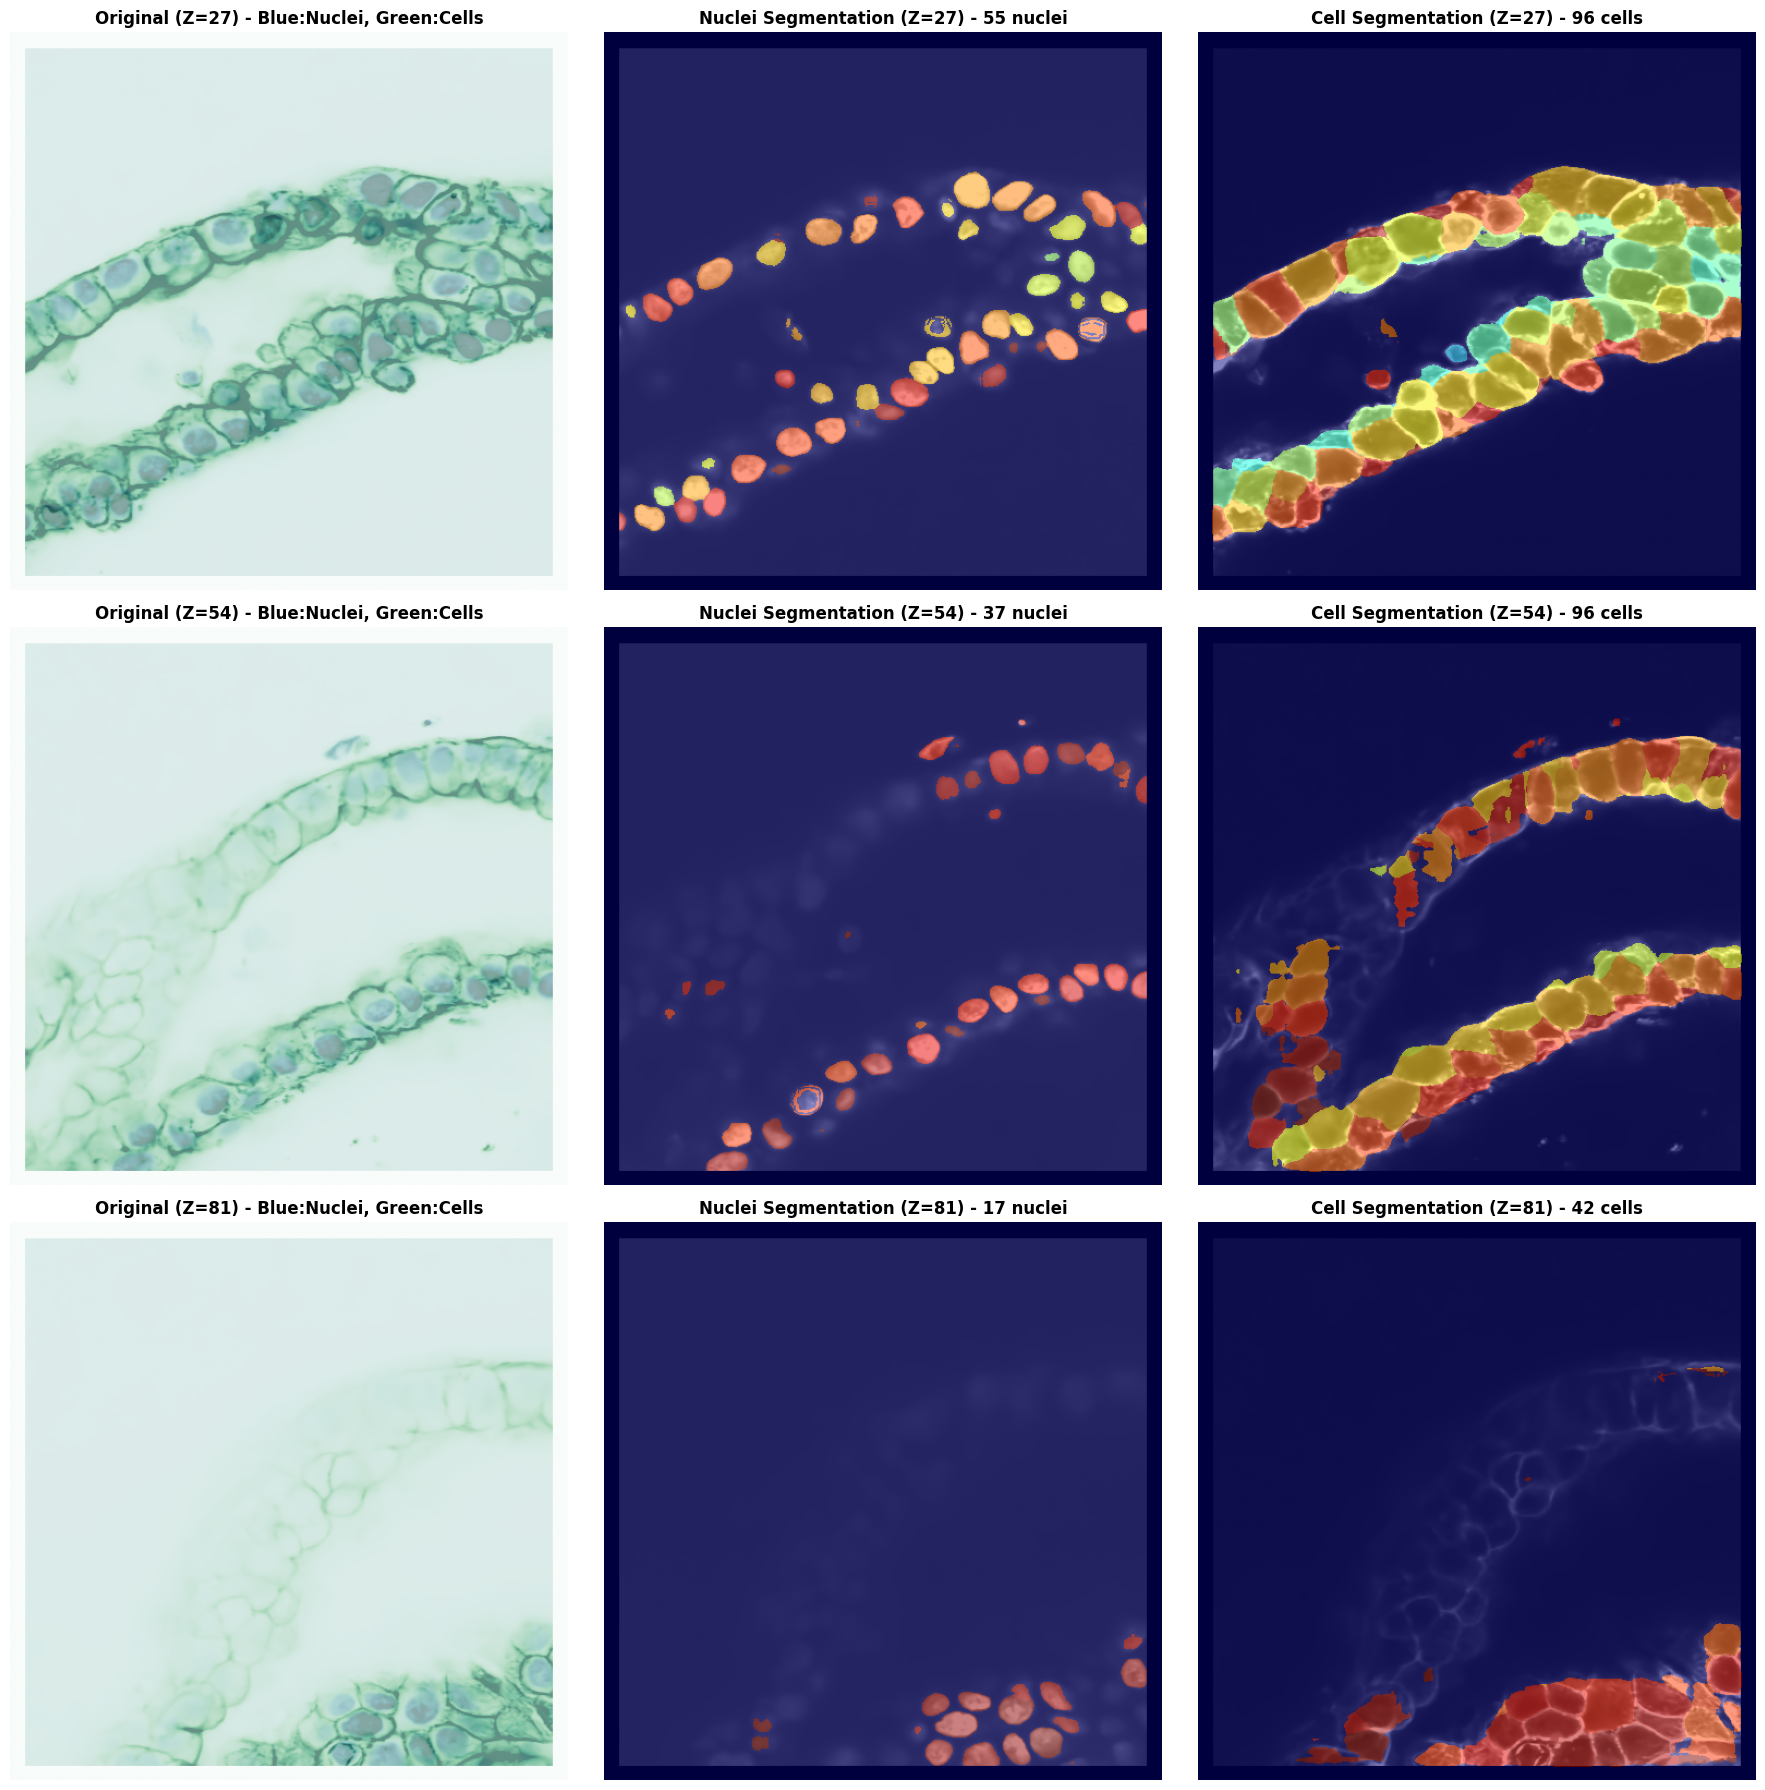


✓ Visualization complete
  Total nuclei: 326
  Total cells: 460


In [ ]:
print("="*60)
print("VISUALIZING 3D SEGMENTATION RESULTS")
print("="*60)

# View multiple slices
slices_to_show = [Z//4, Z//2, 3*Z//4]

fig, axes = plt.subplots(len(slices_to_show), 3, figsize=(18, 6*len(slices_to_show)))

for i, z in enumerate(slices_to_show):
    # Original merged
    axes[i, 0].imshow(nuclei_norm[z], cmap='Blues', alpha=0.7)
    axes[i, 0].imshow(cells_norm[z], cmap='Greens', alpha=0.5)
    axes[i, 0].set_title(f'Original (Z={z}) - Blue:Nuclei, Green:Cells', fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')

    # Nuclei segmentation
    axes[i, 1].imshow(nuclei_norm[z], cmap='gray')
    axes[i, 1].imshow(nuclei_masks_3d[z], alpha=0.5, cmap='jet')
    n_count = len(np.unique(nuclei_masks_3d[z])) - 1
    axes[i, 1].set_title(f'Nuclei Segmentation (Z={z}) - {n_count} nuclei', fontsize=12, fontweight='bold')
    axes[i, 1].axis('off')

    # Cell segmentation
    axes[i, 2].imshow(cells_norm[z], cmap='gray')
    axes[i, 2].imshow(cell_masks_3d[z], alpha=0.5, cmap='jet')
    c_count = len(np.unique(cell_masks_3d[z])) - 1
    axes[i, 2].set_title(f'Cell Segmentation (Z={z}) - {c_count} cells', fontsize=12, fontweight='bold')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete")
print(f"  Total nuclei: {num_nuclei_3d}")
print(f"  Total cells: {num_cells_3d}")


3D SURFACE RENDERING
Rendering 3D surfaces to show advantage of 3D segmentation...
  Rendering cell 158 (1/5)...
  Rendering cell 180 (2/5)...
  Rendering cell 181 (3/5)...
  Rendering cell 182 (4/5)...
  Rendering cell 183 (5/5)...


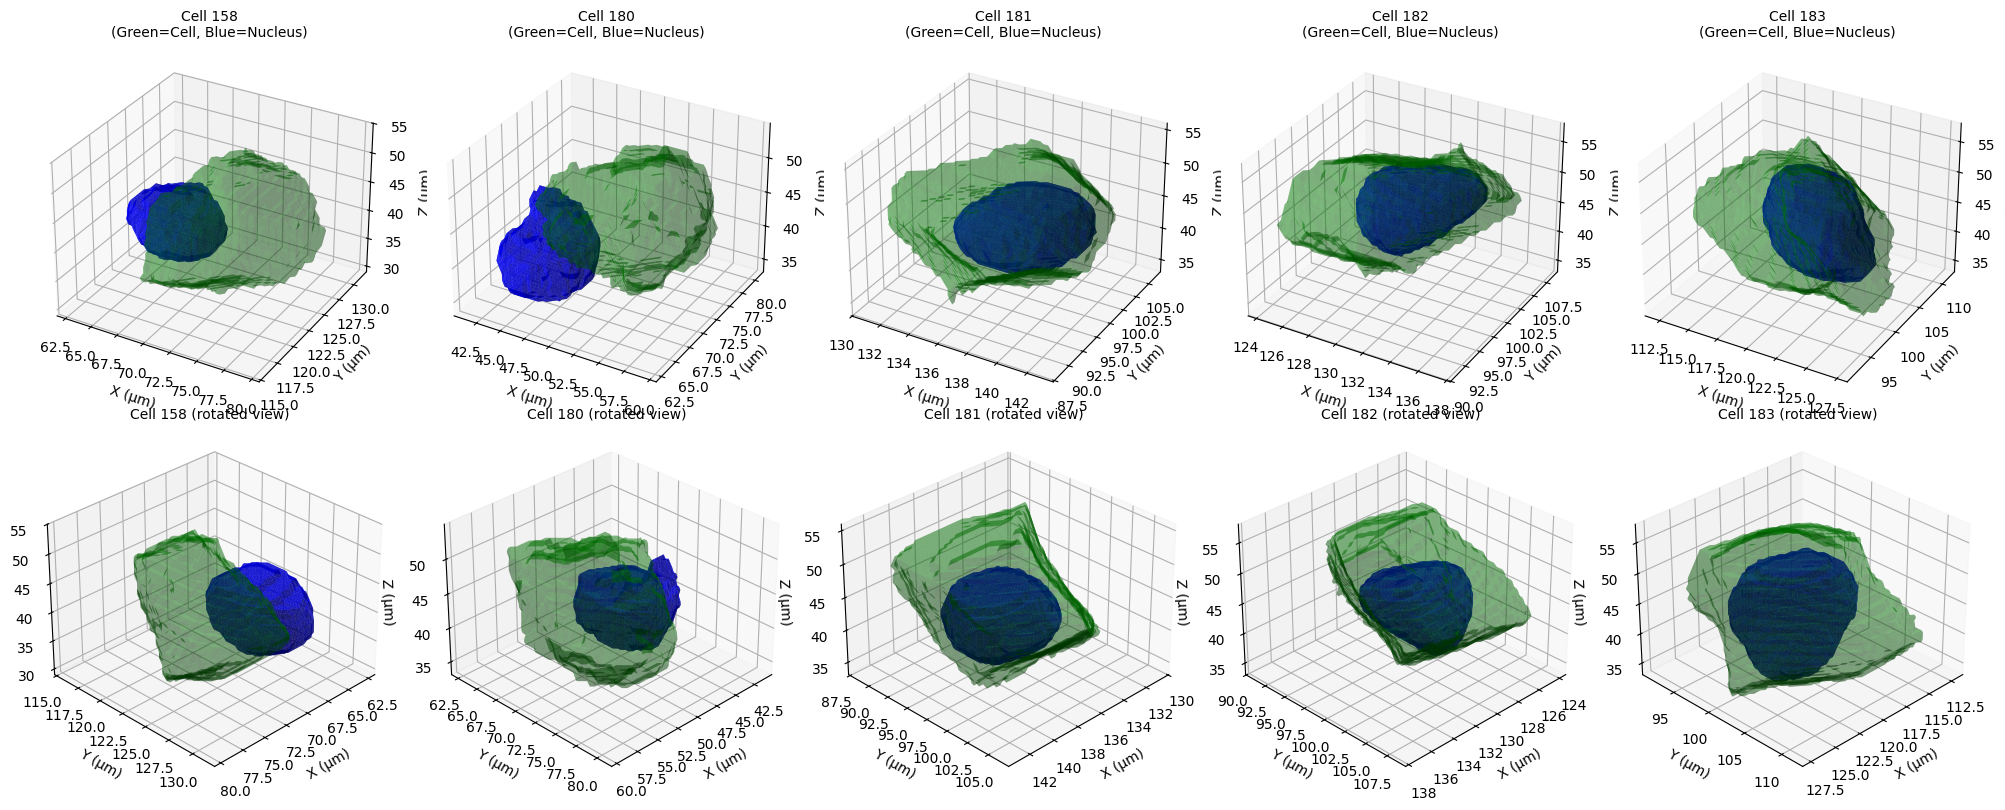


✓ Rendered 5 cells in 3D
✓ 3D segmentation captures full cell volume and nucleus position
✓ This is better than 2D slice-by-slice analysis!



In [ ]:
# ============================================================
# 3D SURFACE RENDERING - Visualize 3D Cell Structure
# Shows that 3D segmentation captures full cell morphology
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

print("\n" + "="*60)
print("3D SURFACE RENDERING")
print("="*60)
print("Rendering 3D surfaces to show advantage of 3D segmentation...")

# Select a few cells to visualize (don't plot all - too slow!)
n_cells_to_plot = 5
available_cell_ids = np.unique(cell_masks_3d)[1:]

# Pick cells from middle slices (more likely to be complete)
middle_slice = Z // 2
cells_in_middle = np.unique(cell_masks_3d[middle_slice])[1:]
cell_ids_to_plot = cells_in_middle[:n_cells_to_plot] if len(cells_in_middle) >= n_cells_to_plot else available_cell_ids[:n_cells_to_plot]

fig = plt.figure(figsize=(20, 8))

for idx, cell_id in enumerate(cell_ids_to_plot):
    print(f"  Rendering cell {cell_id} ({idx+1}/{len(cell_ids_to_plot)})...")

    # Get masks
    cell_mask = cell_masks_3d == cell_id

    # Find corresponding nucleus
    cell_nuclei = nuclei_masks_3d * cell_mask
    nucleus_ids = np.unique(cell_nuclei)[1:]

    if len(nucleus_ids) == 0:
        print(f"    Warning: Cell {cell_id} has no nucleus, skipping...")
        continue

    nucleus_id = nucleus_ids[0]
    nucleus_mask = nuclei_masks_3d == nucleus_id

    # Create 3D surface meshes
    try:
        # Cell surface (green)
        verts_cell, faces_cell, _, _ = measure.marching_cubes(
            cell_mask.astype(float), level=0.5
        )

        # Scale by pixel sizes for correct aspect ratio
        verts_cell_scaled = verts_cell * [PIXEL_SIZE_Z, PIXEL_SIZE_XY, PIXEL_SIZE_XY]

        # Nucleus surface (blue)
        verts_nucleus, faces_nucleus, _, _ = measure.marching_cubes(
            nucleus_mask.astype(float), level=0.5
        )

        verts_nucleus_scaled = verts_nucleus * [PIXEL_SIZE_Z, PIXEL_SIZE_XY, PIXEL_SIZE_XY]

        # Plot - View 1 (default angle)
        ax = fig.add_subplot(2, n_cells_to_plot, idx+1, projection='3d')

        # Cell in green (transparent)
        ax.plot_trisurf(verts_cell_scaled[:, 2], verts_cell_scaled[:, 1], verts_cell_scaled[:, 0],
                       triangles=faces_cell, alpha=0.3, color='green',
                       linewidth=0, antialiased=True)

        # Nucleus in blue (solid)
        ax.plot_trisurf(verts_nucleus_scaled[:, 2], verts_nucleus_scaled[:, 1], verts_nucleus_scaled[:, 0],
                       triangles=faces_nucleus, alpha=0.7, color='blue',
                       linewidth=0, antialiased=True)

        ax.set_title(f'Cell {cell_id}\n(Green=Cell, Blue=Nucleus)', fontsize=10)
        ax.set_xlabel('X (μm)')
        ax.set_ylabel('Y (μm)')
        ax.set_zlabel('Z (μm)')

        # Plot - View 2 (rotated angle)
        ax2 = fig.add_subplot(2, n_cells_to_plot, idx+1+n_cells_to_plot, projection='3d')
        ax2.plot_trisurf(verts_cell_scaled[:, 2], verts_cell_scaled[:, 1], verts_cell_scaled[:, 0],
                        triangles=faces_cell, alpha=0.3, color='green',
                        linewidth=0, antialiased=True)
        ax2.plot_trisurf(verts_nucleus_scaled[:, 2], verts_nucleus_scaled[:, 1], verts_nucleus_scaled[:, 0],
                        triangles=faces_nucleus, alpha=0.7, color='blue',
                        linewidth=0, antialiased=True)
        ax2.view_init(elev=30, azim=45)  # Different viewing angle
        ax2.set_title(f'Cell {cell_id} (rotated view)', fontsize=10)
        ax2.set_xlabel('X (μm)')
        ax2.set_ylabel('Y (μm)')
        ax2.set_zlabel('Z (μm)')

    except Exception as e:
        print(f"    Error rendering cell {cell_id}: {e}")

plt.tight_layout()
plt.show()

print(f"\n✓ Rendered {len(cell_ids_to_plot)} cells in 3D")
print(f"✓ 3D segmentation captures full cell volume and nucleus position")
print(f"✓ This is better than 2D slice-by-slice analysis!\n")

## Quality Control - Match Nuclei to Cells

### Quality Control Logic

#### Step 1: Match Nuclei to Cells

**How it works**:
1. For each cell mask, identify all nucleus pixels that overlap with it
2. If multiple nuclei are found, keep only the largest one
3. Calculate nucleus-to-cell volume ratio (N/C ratio)

**Why it matters**: Ensures accurate pairing for downstream analysis. In rare cases, segmentation errors can assign the wrong nucleus to a cell, or fail to detect a nucleus entirely.

#### Step 2: Filter Low-Quality Cells

**Criteria**:

1. **Minimum cell volume** (500 μm³)
   - Removes small debris, artifacts, or partial cells at image boundaries
   - Volume-based (not pixel-based) for consistency across imaging conditions

2. **Minimum nucleus volume** (100 μm³)
   - Ensures nucleus is well-segmented (not just a few scattered pixels)
   - Poorly segmented nuclei indicate low-quality cells

3. **Require nucleus** (True by default)
   - Cells without nuclei are likely artifacts or incomplete segmentations
   - Essential for nuclear intensity features

4. **Maximum N/C ratio** (0.9)
   - Physically impossible for nucleus volume to exceed cell volume
   - Indicates segmentation error (e.g., cell boundary too tight)
   - Healthy cells typically have N/C ratio of 0.1-0.5

**Result**: Only high-quality, complete cells proceed to feature extraction.

### Load previously saved unfiltered masks, only if working on tuning the filter process post-segmentation and when connected to a new runtime

In [ ]:
"""
# ============================================================
# LOAD PREVIOUSLY SAVED UNFILTERED MASKS
# Use this to skip re-segmentation and jump to quality control
# ============================================================


### Also load other parameters, in case above cells are not executed.
#==================== FILE PATHS ====================
DATA_DIR = "/content/drive/MyDrive/ColabNotebooks/data/3D_Organoid_Analysis/images/"
NUCLEI_FILE = DATA_DIR + "PDAC-C1.tif"  # DAPI/Nuclei channel
CELLS_FILE = DATA_DIR + "PDAC-C2.tif"   # Cytoplasm/Cells channel
OUTPUT_DIR = DATA_DIR + "segmentation_output/"  # Saves to Google Drive!

# ==================== MICROSCOPE PARAMETERS ====================
PIXEL_SIZE_XY = 0.345  # microns per pixel in XY
PIXEL_SIZE_Z = 1.0     # microns per z-slice
ANISOTROPY = PIXEL_SIZE_Z / PIXEL_SIZE_XY

# ==================== VISUALIZATION ====================
SLICE_TO_VIEW = None  # None = middle slice, or specify slice number (e.g., 50)

# ==================== CELL SEGMENTATION PARAMETERS ====================
# NOTE: Cell segmentation uses 2-channel input [cells, nuclei] for better results!
# The nuclei channel helps the model better identify cell boundaries.
CELL_DIAMETER = 50        # pixels - adjust based on your cells
CELL_FLOW_THRESHOLD = 0.6      # 0.0-1.0, HIGHER = more separation (try 0.6-0.8)
CELL_CELLPROB_THRESHOLD = 0.0  # -6 to 6, higher = more stringent

# ==================== NUCLEI SEGMENTATION PARAMETERS ====================
NUCLEI_DIAMETER = 30      # pixels - adjust based on your nuclei
NUCLEI_FLOW_THRESHOLD = 0.4    # 0.0-1.0, lower = more conservative
NUCLEI_CELLPROB_THRESHOLD = 0.0  # -6 to 6, higher = more stringent

# ==================== QUALITY CONTROL ====================
MIN_CELL_VOLUME_UM3 = 500      # minimum cell volume in μm³
MIN_NUCLEUS_VOLUME_UM3 = 100   # minimum nucleus volume in μm³
REQUIRE_NUCLEUS = True         # Only keep cells with nuclei
MAX_NC_RATIO = 0.9             # Maximum nucleus/cell volume ratio (nucleus must be smaller than cell)

# View multiple slices
slices_to_show = [25, 50, 75]

print("✓ Configuration loaded")
print(f"  Anisotropy: {ANISOTROPY:.2f}")
print(f"\n  CELL parameters:")
print(f"    Diameter: {CELL_DIAMETER} pixels")
print(f"    Flow threshold: {CELL_FLOW_THRESHOLD}")
print(f"    Cellprob threshold: {CELL_CELLPROB_THRESHOLD}")
print(f"\n  NUCLEI parameters:")
print(f"    Diameter: {NUCLEI_DIAMETER} pixels")
print(f"    Flow threshold: {NUCLEI_FLOW_THRESHOLD}")
print(f"    Cellprob threshold: {NUCLEI_CELLPROB_THRESHOLD}")
print(f"\n  QUALITY CONTROL:")
print(f"    Min cell volume: {MIN_CELL_VOLUME_UM3} μm³")
print(f"    Min nucleus volume: {MIN_NUCLEUS_VOLUME_UM3} μm³")
print(f"    Max N/C ratio: {MAX_NC_RATIO}")

import numpy as np
import tifffile as tiff


print("="*60)
print("LOADING UNFILTERED SEGMENTATION MASKS")
print("="*60)

# Path to saved masks
OUTPUT_DIR = DATA_DIR + "segmentation_output/"

print(f"\nLoading from: {OUTPUT_DIR}")

# Load unfiltered masks
cell_masks_3d = tiff.imread(OUTPUT_DIR + "cell_masks_3D_unfiltered.tif")
print(f"✓ Loaded: cell_masks_3D_unfiltered.tif")
print(f"  Shape: {cell_masks_3d.shape}")
print(f"  Data type: {cell_masks_3d.dtype}")

nuclei_masks_3d = tiff.imread(OUTPUT_DIR + "nuclei_masks_3D_unfiltered.tif")
print(f"✓ Loaded: nuclei_masks_3D_unfiltered.tif")
print(f"  Shape: {nuclei_masks_3d.shape}")
print(f"  Data type: {nuclei_masks_3d.dtype}")

# Get counts
num_cells_3d = cell_masks_3d.max()
num_nuclei_3d = nuclei_masks_3d.max()

print(f"\n✓ Masks loaded successfully")
print(f"  Total cells: {num_cells_3d}")
print(f"  Total nuclei: {num_nuclei_3d}")

print("\n✓ Ready to proceed to quality control!")



"""



✓ Configuration loaded
  Anisotropy: 2.90

  CELL parameters:
    Diameter: 50 pixels
    Flow threshold: 0.6
    Cellprob threshold: 0.0

  NUCLEI parameters:
    Diameter: 30 pixels
    Flow threshold: 0.4
    Cellprob threshold: 0.0

  QUALITY CONTROL:
    Min cell volume: 500 μm³
    Min nucleus volume: 100 μm³
    Max N/C ratio: 0.9
LOADING UNFILTERED SEGMENTATION MASKS

Loading from: /content/drive/MyDrive/ColabNotebooks/data/3D_Organoid_Analysis/images/segmentation_output/
✓ Loaded: cell_masks_3D_unfiltered.tif
  Shape: (109, 512, 512)
  Data type: uint16
✓ Loaded: nuclei_masks_3D_unfiltered.tif
  Shape: (109, 512, 512)
  Data type: uint16

✓ Masks loaded successfully
  Total cells: 460
  Total nuclei: 326

✓ Ready to proceed to quality control!


### Step 1: Match Nuclei and Cells
This step takes time...

In [ ]:
print("="*60)
print("QUALITY CONTROL - MATCHING NUCLEI TO CELLS")
print("="*60)

print(f"\nBefore filtering:")
print(f"  Total cells: {num_cells_3d}")
print(f"  Total nuclei: {num_nuclei_3d}")

# Build cell-nucleus mapping
print("\nAnalyzing cell-nucleus relationships...")

# Calculate voxel volume for conversions
voxel_volume_um3 = (PIXEL_SIZE_XY ** 2) * PIXEL_SIZE_Z

cell_info = {}
cell_ids = np.unique(cell_masks_3d)[1:]  # Skip background

for cell_id in cell_ids:
    cell_mask = cell_masks_3d == cell_id
    cell_volume_voxels = np.sum(cell_mask)
    cell_volume_um3 = cell_volume_voxels * voxel_volume_um3  # Convert to μm³

    # Find nuclei within this cell
    cell_nuclei = nuclei_masks_3d * cell_mask
    nucleus_ids = np.unique(cell_nuclei)[1:]  # Skip background

    if len(nucleus_ids) > 0:
        # Use largest nucleus if multiple
        nucleus_volumes_voxels = [np.sum(cell_nuclei == nid) for nid in nucleus_ids]
        max_idx = np.argmax(nucleus_volumes_voxels)
        nucleus_id = nucleus_ids[max_idx]
        nucleus_volume_voxels = nucleus_volumes_voxels[max_idx]
        nucleus_volume_um3 = nucleus_volume_voxels * voxel_volume_um3  # Convert to μm³
        has_nucleus = True

        # Calculate N/C ratio
        nc_ratio = nucleus_volume_um3 / cell_volume_um3 if cell_volume_um3 > 0 else 0
    else:
        nucleus_id = 0
        nucleus_volume_voxels = 0
        nucleus_volume_um3 = 0
        has_nucleus = False
        nc_ratio = 0

    cell_info[cell_id] = {
        'cell_volume_voxels': cell_volume_voxels,
        'cell_volume_um3': cell_volume_um3,
        'nucleus_id': nucleus_id,
        'nucleus_volume_voxels': nucleus_volume_voxels,
        'nucleus_volume_um3': nucleus_volume_um3,
        'has_nucleus': has_nucleus,
        'nc_ratio': nc_ratio
    }

# Statistics
cells_with_nuclei = sum(1 for info in cell_info.values() if info['has_nucleus'])
cells_without_nuclei = len(cell_info) - cells_with_nuclei

print(f"\n✓ Analysis complete:")
print(f"  Cells with nuclei: {cells_with_nuclei}")
print(f"  Cells without nuclei: {cells_without_nuclei}")
print(f"  Match rate: {cells_with_nuclei/len(cell_info)*100:.1f}%")

QUALITY CONTROL - MATCHING NUCLEI TO CELLS

Before filtering:
  Total cells: 460
  Total nuclei: 326

Analyzing cell-nucleus relationships...

✓ Analysis complete:
  Cells with nuclei: 326
  Cells without nuclei: 134
  Match rate: 70.9%


Step 2: Filter Low-Quality Cells

In [ ]:
# ==================== FILTER SETTINGS ====================
MIN_CELL_VOLUME_UM3 = 500      # minimum cell volume in μm³
MIN_NUCLEUS_VOLUME_UM3 = 100   # minimum nucleus volume in μm³
REQUIRE_NUCLEUS = True         # Only keep cells with nuclei
MAX_NC_RATIO = 0.9             # Maximum nucleus/cell volume ratio (nucleus must be smaller than cell)

print("✓ Configuration loaded")
print(f"  Anisotropy: {ANISOTROPY:.2f}")
print(f"\n  CELL parameters:")
print(f"    Diameter: {CELL_DIAMETER} pixels")
print(f"    Flow threshold: {CELL_FLOW_THRESHOLD}")
print(f"    Cellprob threshold: {CELL_CELLPROB_THRESHOLD}")
print(f"\n  NUCLEI parameters:")
print(f"    Diameter: {NUCLEI_DIAMETER} pixels")
print(f"    Flow threshold: {NUCLEI_FLOW_THRESHOLD}")
print(f"    Cellprob threshold: {NUCLEI_CELLPROB_THRESHOLD}")
print(f"\n  QUALITY CONTROL:")
print(f"    Min cell volume: {MIN_CELL_VOLUME_UM3} μm³")
print(f"    Min nucleus volume: {MIN_NUCLEUS_VOLUME_UM3} μm³")
print(f"    Max N/C ratio: {MAX_NC_RATIO}")

✓ Configuration loaded
  Anisotropy: 2.90

  CELL parameters:
    Diameter: 50 pixels
    Flow threshold: 0.6
    Cellprob threshold: 0.0

  NUCLEI parameters:
    Diameter: 30 pixels
    Flow threshold: 0.4
    Cellprob threshold: 0.0

  QUALITY CONTROL:
    Min cell volume: 500 μm³
    Min nucleus volume: 100 μm³
    Max N/C ratio: 0.9


In [ ]:
print("="*60)
print("FILTERING CELLS")
print("="*60)

print(f"\nFiltering criteria:")
print(f"  Min cell volume: {MIN_CELL_VOLUME_UM3} μm³")
print(f"  Min nucleus volume: {MIN_NUCLEUS_VOLUME_UM3} μm³")
print(f"  Require nucleus: {REQUIRE_NUCLEUS}")
print(f"  Max N/C ratio: {MAX_NC_RATIO} (ensures nucleus fits inside cell)")

# Filter cells
cells_to_keep = []
cells_removed_too_small = 0
cells_removed_no_nucleus = 0
nuclei_removed_too_small = 0
cells_removed_nc_ratio = 0

for cell_id, info in cell_info.items():
    # Check cell size (in μm³)
    if info['cell_volume_um3'] < MIN_CELL_VOLUME_UM3:
        cells_removed_too_small += 1
        continue

    # Check nucleus requirement
    if REQUIRE_NUCLEUS and not info['has_nucleus']:
        cells_removed_no_nucleus += 1
        continue

    # Check nucleus size (in μm³)
    if info['has_nucleus'] and info['nucleus_volume_um3'] < MIN_NUCLEUS_VOLUME_UM3:
        nuclei_removed_too_small += 1
        continue

    # Check N/C ratio (nucleus must be smaller than cell)
    if info['has_nucleus'] and info['nc_ratio'] > MAX_NC_RATIO:
        cells_removed_nc_ratio += 1
        continue

    cells_to_keep.append(cell_id)

print(f"\nFiltering results:")
print(f"  Cells removed (too small): {cells_removed_too_small}")
print(f"  Cells removed (no nucleus): {cells_removed_no_nucleus}")
print(f"  Cells removed (nucleus too small): {nuclei_removed_too_small}")
print(f"  Cells removed (N/C ratio too high): {cells_removed_nc_ratio}")
print(f"  Cells kept: {len(cells_to_keep)}")
print(f"  Filtering rate: {(1 - len(cells_to_keep)/len(cell_info))*100:.1f}% removed")

# Create filtered masks
print("\nCreating filtered masks...")
cell_masks_filtered = np.zeros_like(cell_masks_3d)
nuclei_masks_filtered = np.zeros_like(nuclei_masks_3d)

for new_id, old_id in enumerate(cells_to_keep, start=1):
    cell_mask = cell_masks_3d == old_id
    cell_masks_filtered[cell_mask] = new_id

    # Also keep corresponding nucleus
    nucleus_id = cell_info[old_id]['nucleus_id']
    if nucleus_id > 0:
        nucleus_mask = nuclei_masks_3d == nucleus_id
        nuclei_masks_filtered[nucleus_mask] = new_id  # Use same ID as cell

num_cells_filtered = cell_masks_filtered.max()
num_nuclei_filtered = nuclei_masks_filtered.max()

print(f"\n✓ Filtered masks created")
print(f"  Final cell count: {num_cells_filtered}")
print(f"  Final nucleus count: {num_nuclei_filtered}")

# Show volume statistics of kept cells
if len(cells_to_keep) > 0:
    kept_cell_volumes = [cell_info[cid]['cell_volume_um3'] for cid in cells_to_keep]
    kept_nucleus_volumes = [cell_info[cid]['nucleus_volume_um3'] for cid in cells_to_keep]
    kept_nc_ratios = [cell_info[cid]['nc_ratio'] for cid in cells_to_keep]

    print(f"\n✓ Volume statistics of kept cells:")
    print(f"  Cell volume range: {np.min(kept_cell_volumes):.1f} - {np.max(kept_cell_volumes):.1f} μm³")
    print(f"  Nucleus volume range: {np.min(kept_nucleus_volumes):.1f} - {np.max(kept_nucleus_volumes):.1f} μm³")
    print(f"  N/C ratio range: {np.min(kept_nc_ratios):.3f} - {np.max(kept_nc_ratios):.3f}")

FILTERING CELLS

Filtering criteria:
  Min cell volume: 500 μm³
  Min nucleus volume: 100 μm³
  Require nucleus: True
  Max N/C ratio: 0.9 (ensures nucleus fits inside cell)

Filtering results:
  Cells removed (too small): 159
  Cells removed (no nucleus): 10
  Cells removed (nucleus too small): 15
  Cells removed (N/C ratio too high): 0
  Cells kept: 276
  Filtering rate: 40.0% removed

Creating filtered masks...

✓ Filtered masks created
  Final cell count: 276
  Final nucleus count: 276

✓ Volume statistics of kept cells:
  Cell volume range: 502.9 - 2920.3 μm³
  Nucleus volume range: 103.5 - 908.1 μm³
  N/C ratio range: 0.097 - 0.618


## Visualize Filtered Results

3D VISUALIZATION


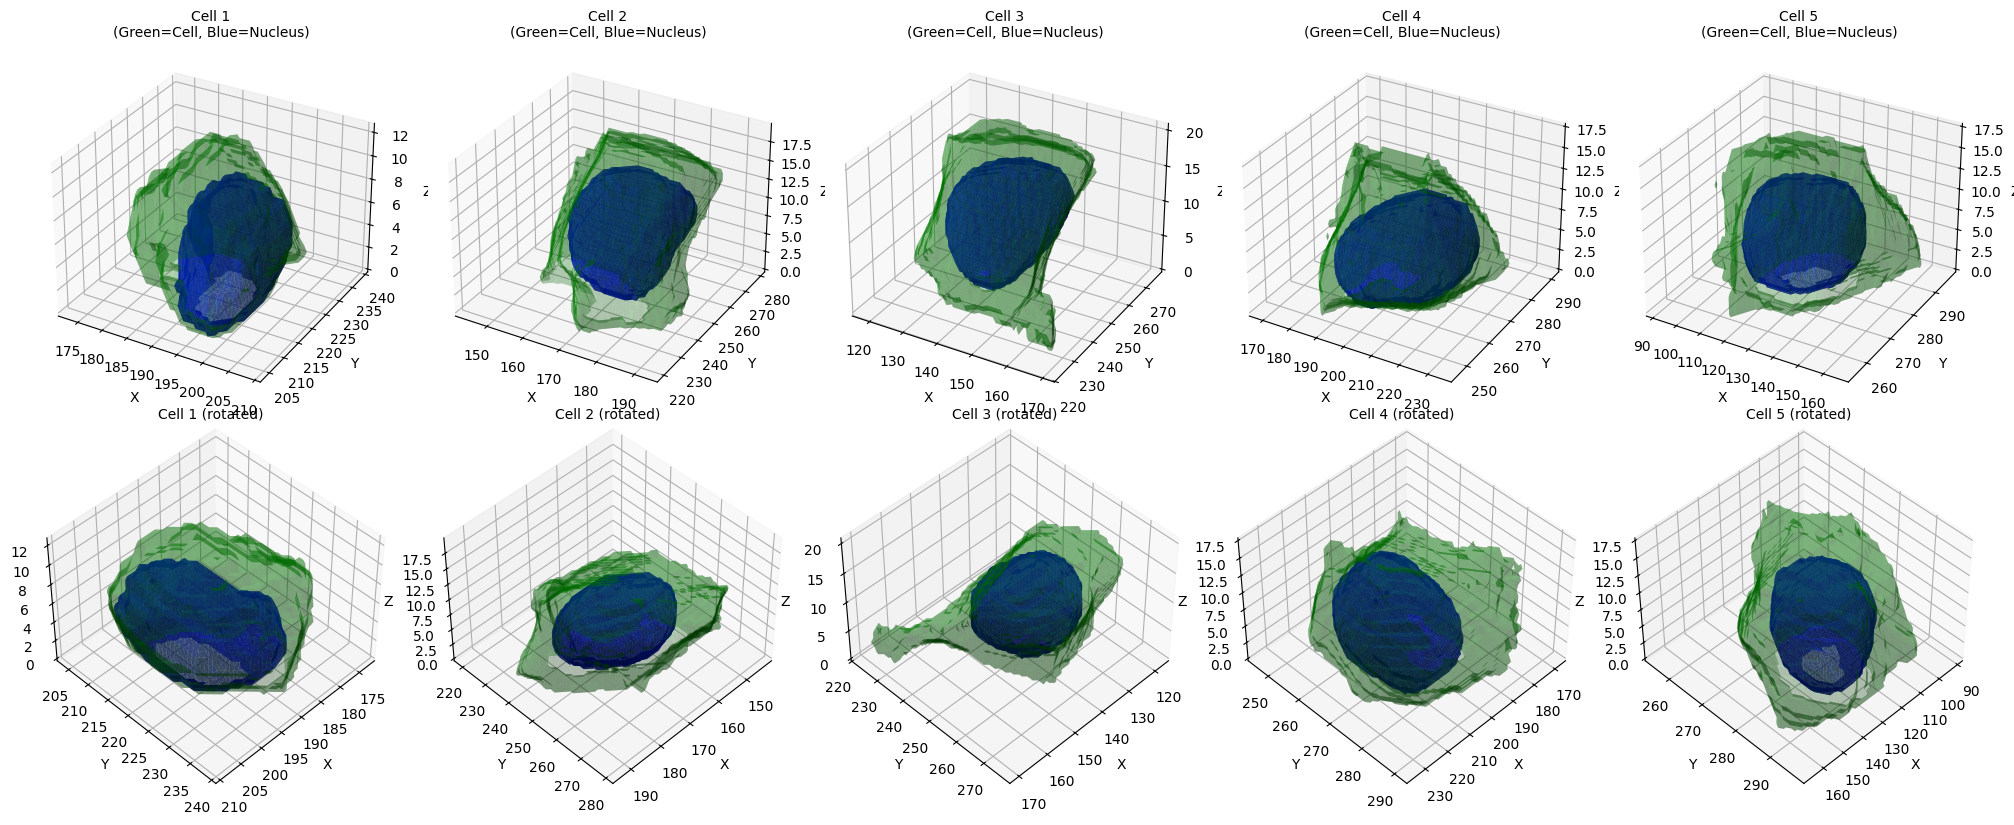

✓ Rendered 5 cells in 3D


In [ ]:
# ============================================================
# 3D VISUALIZATION - Multiple Views
# Shows 3D structure of cells and nuclei
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

print("="*60)
print("3D VISUALIZATION")
print("="*60)

# ==================== 3D SURFACE RENDERING ====================

# Select a few cells to visualize (don't plot all - too slow!)
n_cells_to_plot = 5
cell_ids_to_plot = np.unique(cell_masks_filtered)[1:n_cells_to_plot+1]

fig = plt.figure(figsize=(20, 8))

for idx, cell_id in enumerate(cell_ids_to_plot):
    # Get masks
    cell_mask = cell_masks_filtered == cell_id
    nucleus_mask = nuclei_masks_filtered == cell_id

    # Create 3D surface meshes
    try:
        # Cell surface
        verts_cell, faces_cell, _, _ = measure.marching_cubes(
            cell_mask.astype(float), level=0.5
        )

        # Nucleus surface
        verts_nucleus, faces_nucleus, _, _ = measure.marching_cubes(
            nucleus_mask.astype(float), level=0.5
        )

        # Plot
        ax = fig.add_subplot(2, n_cells_to_plot, idx+1, projection='3d')

        # Cell in green
        ax.plot_trisurf(verts_cell[:, 2], verts_cell[:, 1], verts_cell[:, 0],
                       triangles=faces_cell, alpha=0.3, color='green',
                       linewidth=0, antialiased=True)

        # Nucleus in blue
        ax.plot_trisurf(verts_nucleus[:, 2], verts_nucleus[:, 1], verts_nucleus[:, 0],
                       triangles=faces_nucleus, alpha=0.7, color='blue',
                       linewidth=0, antialiased=True)

        ax.set_title(f'Cell {cell_id}\n(Green=Cell, Blue=Nucleus)', fontsize=10)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        # Second view from different angle
        ax2 = fig.add_subplot(2, n_cells_to_plot, idx+1+n_cells_to_plot, projection='3d')
        ax2.plot_trisurf(verts_cell[:, 2], verts_cell[:, 1], verts_cell[:, 0],
                        triangles=faces_cell, alpha=0.3, color='green',
                        linewidth=0, antialiased=True)
        ax2.plot_trisurf(verts_nucleus[:, 2], verts_nucleus[:, 1], verts_nucleus[:, 0],
                        triangles=faces_nucleus, alpha=0.7, color='blue',
                        linewidth=0, antialiased=True)
        ax2.view_init(elev=45, azim=45)  # Different viewing angle
        ax2.set_title(f'Cell {cell_id} (rotated)', fontsize=10)
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')

    except Exception as e:
        print(f"  Skipping cell {cell_id}: {e}")

plt.tight_layout()
plt.show()

print(f"✓ Rendered {len(cell_ids_to_plot)} cells in 3D")



## Save Results

In [ ]:
print("="*60)
print("SAVING RESULTS")
print("="*60)

output_path = Path(OUTPUT_DIR)
output_path.mkdir(exist_ok=True, parents=True)

print(f"\nSaving to: {output_path.absolute()}")

# Save filtered masks
tiff.imwrite(output_path / 'cell_masks_3D_filtered.tif', cell_masks_filtered.astype(np.uint16))
print("✓ Saved: cell_masks_3D_filtered.tif")

tiff.imwrite(output_path / 'nuclei_masks_3D_filtered.tif', nuclei_masks_filtered.astype(np.uint16))
print("✓ Saved: nuclei_masks_3D_filtered.tif")

# Also save unfiltered for comparison
tiff.imwrite(output_path / 'cell_masks_3D_unfiltered.tif', cell_masks_3d.astype(np.uint16))
print("✓ Saved: cell_masks_3D_unfiltered.tif")

tiff.imwrite(output_path / 'nuclei_masks_3D_unfiltered.tif', nuclei_masks_3d.astype(np.uint16))
print("✓ Saved: nuclei_masks_3D_unfiltered.tif")

# Save summary
with open(output_path / 'segmentation_summary.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("3D ORGANOID SEGMENTATION SUMMARY\n")
    f.write("="*60 + "\n\n")
    f.write("IMAGE INFO:\n")
    f.write(f"  Nuclei file: {NUCLEI_FILE}\n")
    f.write(f"  Cells file: {CELLS_FILE}\n")
    f.write(f"  Dimensions: {Z} × {Y} × {X}\n\n")
    f.write("SEGMENTATION PARAMETERS:\n")
    f.write(f"  Cell diameter: {CELL_DIAMETER} pixels\n")
    f.write(f"  Nuclei diameter: {NUCLEI_DIAMETER} pixels\n")
    f.write(f"  Anisotropy: {ANISOTROPY:.2f}\n")
    f.write(f"  Cell flow threshold: {CELL_FLOW_THRESHOLD}\n")
    f.write(f"  Cell cellprob threshold: {CELL_CELLPROB_THRESHOLD}\n")
    f.write(f"  Nuclei flow threshold: {NUCLEI_FLOW_THRESHOLD}\n")
    f.write(f"  Nuclei cellprob threshold: {NUCLEI_CELLPROB_THRESHOLD}\n\n")
    f.write("RESULTS (BEFORE FILTERING):\n")
    f.write(f"  Total cells: {num_cells_3d}\n")
    f.write(f"  Total nuclei: {num_nuclei_3d}\n\n")
    f.write("QUALITY CONTROL:\n")
    f.write(f"  Min cell volume: {MIN_CELL_VOLUME_UM3} μm³\n")
    f.write(f"  Min nucleus volume: {MIN_NUCLEUS_VOLUME_UM3} μm³\n")
    f.write(f"  Max N/C ratio: {MAX_NC_RATIO}\n")
    f.write(f"  Cells removed (too small): {cells_removed_too_small}\n")
    f.write(f"  Cells removed (no nucleus): {cells_removed_no_nucleus}\n")
    f.write(f"  Cells removed (nucleus too small): {nuclei_removed_too_small}\n")
    f.write(f"  Cells removed (N/C ratio too high): {cells_removed_nc_ratio}\n\n")
    f.write("RESULTS (AFTER FILTERING):\n")
    f.write(f"  Final cells: {num_cells_filtered}\n")
    f.write(f"  Final nuclei: {num_nuclei_filtered}\n")
    f.write(f"  Filtering rate: {(1 - num_cells_filtered/num_cells_3d)*100:.1f}% removed\n")

print("✓ Saved: segmentation_summary.txt")

print("\n" + "="*60)
print("SEGMENTATION COMPLETE!")
print("="*60)
print(f"\nFinal results:")
print(f"  {num_cells_filtered} high-quality cells")
print(f"  All cells have valid nuclei")
print(f"  Ready for morphological analysis!")
print(f"\nFiles saved to: {output_path.absolute()}")

SAVING RESULTS

Saving to: /content/drive/MyDrive/ColabNotebooks/data/3D_Organoid_Analysis/images/segmentation_output
✓ Saved: cell_masks_3D_filtered.tif
✓ Saved: nuclei_masks_3D_filtered.tif
✓ Saved: cell_masks_3D_unfiltered.tif
✓ Saved: nuclei_masks_3D_unfiltered.tif
✓ Saved: segmentation_summary.txt

SEGMENTATION COMPLETE!

Final results:
  276 high-quality cells
  All cells have valid nuclei
  Ready for morphological analysis!

Files saved to: /content/drive/MyDrive/ColabNotebooks/data/3D_Organoid_Analysis/images/segmentation_output


## Next Steps: Morphological Analysis

Now that you have high-quality segmentation, you can:
1. Extract morphological features (volume, surface area, sphericity, etc.)
2. Calculate nuclear-cytoplasmic ratios
3. Measure intensity metrics
4. Analyze spatial distributions
5. Compare across conditions

The filtered masks are ready for regionprops analysis!

### Feature Extraction Overview

We calculate **27 features per cell** across four categories:

#### 1. Base Morphology Features (6 features)

- **`cell_volume_um3`**: Total cell volume in cubic micrometers. Direct measure of cell size.

- **`nuclei_volume_um3`**: Nucleus volume in cubic micrometers. Important for N/C ratio.

- **`cell_elongation`**: Ratio of major axis to minor axis. Values >1 indicate elongated cells, =1 indicates spherical cells. Useful for identifying cell types (e.g., elongated fibroblasts vs round lymphocytes).

- **`cell_roundedness`**: Inverse of elongation (minor/major axis). Another way to express the same shape information. Values close to 1 = round.

- **`major_axis_um`**: Length of the longest axis through the cell (in μm). From 2D projection of 3D cell.

- **`minor_axis_um`**: Length of the shortest axis perpendicular to major axis (in μm).

#### 2. Intensity Features (6 features) - Nuclear Channel Only

- **`CV_chromatin`**: Coefficient of variation (std/mean) of DAPI intensity within nucleus. Measures chromatin texture/heterogeneity. High CV indicates clumped chromatin (e.g., condensed chromosomes during mitosis). Low CV indicates diffuse chromatin.

- **`max_intensity_nuclear`**: Brightest pixel in nucleus. Can indicate bright spots or condensed chromatin regions.

- **`min_intensity_nuclear`**: Dimmest pixel in nucleus. Useful for background subtraction or quality checks.

- **`avg_intensity_nuclear`**: Mean DAPI intensity. Correlates with DNA content (G1 vs G2 cells have different amounts).

- **`std_intensity_nuclear`**: Standard deviation of nuclear intensity. Measures variability (similar to CV but not normalized by mean).

- **`sum_intensity_nuclear`**: Total integrated intensity (sum of all nuclear pixels). Proportional to total DNA content, useful for cell cycle analysis.

#### 3. Topology Features (7 features) - Spatial Relationships

These features describe how cells are arranged relative to each other:

- **`distance_to_neighbors_mean_um`**: Average distance from this cell's centroid to its neighbors' centroids (within 20 μm radius). Indicates local cell-cell spacing.

- **`distance_to_neighbors_min_um`**: Distance to the closest neighboring cell. Identifies tightly packed vs isolated cells.

- **`distance_to_neighbors_max_um`**: Distance to the farthest neighbor within the search radius.

- **`n_nuclei_neighbors`**: Count of neighboring cells within 20 μm radius. Measures local crowding/density.

- **`local_density_per_mm3`**: Number of neighbors divided by sphere volume, converted to cells per cubic millimeter. Standardized density metric that accounts for search radius.

- **`crystal_distance_um`**: If cells were arranged in a perfect cubic lattice at the observed local density, what would the cell-to-cell spacing be?
  - **Formula**: `(volume_per_cell)^(1/3)` where `volume_per_cell = 1/local_density`
  - **Interpretation**: Lower values = tightly packed or regular arrangement. Higher values = loosely packed or irregular spacing.
  - **Example**: Crystal distance of 20 μm means each cell would occupy a 20×20×20 μm cube in a perfect lattice.

- **`nb_nuclei_neighbors_ripley`**: Ripley-corrected neighbor count. Accounts for edge effects (cells near image boundaries can't have neighbors outside the field of view). This correction makes density measurements more accurate by estimating how many neighbors would be present if the image extended infinitely.

#### 4. 3D Shape Features (8 features) - From Inertia Tensor

These features come from 3D eigenvalue decomposition of the cell's coordinate distribution:

- **`major_axis_um`**: Length of the longest principal axis in 3D (in μm). This is different from the 2D major axis above - it captures the true 3D extent.

- **`medium_axis_um`**: Length of the intermediate principal axis (in μm). The second-longest dimension.

- **`minor_axis_um`**: Length of the shortest principal axis (in μm). The narrowest dimension.

- **`prolate_ratio`**: major/medium axis ratio. Measures "football-like" elongation.
  - **Interpretation**: Ratio >1 indicates elongation along one primary direction (like a football or cigar shape).
  - **Example**: 3.0 means the cell is 3× longer than it is wide.

- **`oblate_ratio`**: medium/minor axis ratio. Measures "pancake-like" flattening.
  - **Interpretation**: Ratio >1 indicates flattening (like a pancake or disc).
  - **Example**: 3.0 means the cell is 3× wider than it is thick.

**Shape interpretation guide**:
- **Sphere**: prolate ≈ 1, oblate ≈ 1
- **Football/Cigar**: prolate >> 1, oblate ≈ 1 (elongated in one direction)
- **Pancake/Disc**: prolate ≈ 1, oblate >> 1 (flattened)
- **Needle**: prolate >> 1, oblate >> 1 (elongated AND thin)

### Feature Extraction Performance

- **Speed**: ~1-2 minutes per 100 cells
- **Bottlenecks**: 3D shape analysis (eigenvalue decomposition), spatial queries
- **Optional slow features**: Distance-to-border features (skipped by default) add ~10 seconds per cell

### Note on Distance-to-Border Features (Optional)

Two features are **not** calculated by default because they are extremely slow:

- **`nuclei_distance_to_border_um`**: Distance from nucleus center to nearest cell edge (in μm). Indicates how centrally positioned the nucleus is.

- **`nuclei_distance_to_border_ratio`**: Same distance normalized by cell radius (0 = nucleus at edge, 1 = nucleus at center).

**Why slow?**: Requires computing a 3D Euclidean distance transform for every cell, which is computationally expensive.

**When to use**: Only if nuclear positioning is critical for your biological question (e.g., studying nuclear polarity or migration).

See the optional cell at the end if you need these features.

---
# LOADING SAVED SEGMENTATION RESULTS
## Use this section to load previously saved masks without re-segmenting

In [ ]:
# ============================================================
# LOAD SAVED MASKS (Run this instead of segmentation cells)
# ============================================================

import numpy as np
import tifffile as tiff
from pathlib import Path

print("="*60)
print("LOADING SAVED SEGMENTATION MASKS")
print("="*60)


# Path to saved results
DATA_DIR = "/content/drive/MyDrive/ColabNotebooks/data/3D_Organoid_Analysis/images/"
RESULTS_DIR = DATA_DIR + "segmentation_output/"

print(f"\nLoading from: {RESULTS_DIR}")

# Load filtered masks (these are the good ones!)
cell_masks_filtered = tiff.imread(RESULTS_DIR + "cell_masks_3D_filtered.tif")
print(f"✓ Loaded: cell_masks_3D_filtered.tif")
print(f"  Shape: {cell_masks_filtered.shape}")
print(f"  Number of cells: {cell_masks_filtered.max()}")

nuclei_masks_filtered = tiff.imread(RESULTS_DIR + "nuclei_masks_3D_filtered.tif")
print(f"✓ Loaded: nuclei_masks_3D_filtered.tif")
print(f"  Shape: {nuclei_masks_filtered.shape}")
print(f"  Number of nuclei: {nuclei_masks_filtered.max()}")

# Also load original images, we need them for intensity measurements
nuclei = tiff.imread(DATA_DIR + "PDAC-C1.tif")
cells = tiff.imread(DATA_DIR + "PDAC-C2.tif")
print(f"\n✓ Also loaded original images")

print("\n" + "="*60)
print("READY FOR ANALYSIS!")
print("="*60)
print("\nYou now have:")
print("  - cell_masks_filtered (3D cell segmentation)")
print("  - nuclei_masks_filtered (3D nuclei segmentation)")
print("  - cells (original cell channel)")
print("  - nuclei (original nuclei channel)")
print("\nProceed to morphological analysis!")

LOADING SAVED SEGMENTATION MASKS

Loading from: /content/drive/MyDrive/ColabNotebooks/data/3D_Organoid_Analysis/images/segmentation_output/
✓ Loaded: cell_masks_3D_filtered.tif
  Shape: (109, 512, 512)
  Number of cells: 276
✓ Loaded: nuclei_masks_3D_filtered.tif
  Shape: (109, 512, 512)
  Number of nuclei: 276

✓ Also loaded original images

READY FOR ANALYSIS!

You now have:
  - cell_masks_filtered (3D cell segmentation)
  - nuclei_masks_filtered (3D nuclei segmentation)
  - cells (original cell channel)
  - nuclei (original nuclei channel)

Proceed to morphological analysis!


In [ ]:
# ============================================================
# FEATURE EXTRACTION - 3D ORGANOID ANALYSIS
#
# ============================================================

import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from skimage import measure
import tifffile as tiff
from pathlib import Path
import time

print("="*60)
print("LIGHTNING-FAST 3D FEATURE EXTRACTION")
print("="*60)
print("Note: Skipping nuclei_distance_to_border features (saves 95% time)")

# ==================== METADATA ====================
BATCH = "Batch1"
SAMPLE = "PDAC"
WELL = "A01"
FIELD = "s1"
RADIUS_UM = 20.0

start_time = time.time()

# ==================== STEP 1: BATCH REGIONPROPS ====================
print("\n[Step 1/4] Extracting regionprops...")
step_start = time.time()

cell_props_all = measure.regionprops(cell_masks_filtered)
nuclei_props_all = measure.regionprops(nuclei_masks_filtered, intensity_image=nuclei)

cell_props_dict = {prop.label: prop for prop in cell_props_all}
nuclei_props_dict = {prop.label: prop for prop in nuclei_props_all}

cell_ids = np.array([prop.label for prop in cell_props_all])
n_cells = len(cell_ids)

print(f"  ✓ {n_cells} cells in {time.time() - step_start:.1f}s")

# ==================== STEP 2: VECTORIZED CENTROIDS ====================
print(f"\n[Step 2/4] Extracting centroids...")
step_start = time.time()

all_centroids = np.array([
    [
        prop.centroid[0] * PIXEL_SIZE_Z,
        prop.centroid[1] * PIXEL_SIZE_XY,
        prop.centroid[2] * PIXEL_SIZE_XY
    ]
    for prop in cell_props_all
])

cell_id_to_idx = {cell_id: idx for idx, cell_id in enumerate(cell_ids)}

print(f"  ✓ {n_cells} centroids in {time.time() - step_start:.1f}s")

# ==================== STEP 3: BUILD KDTREE & QUERY NEIGHBORS ====================
print(f"\n[Step 3/4] Building KDTree and querying neighbors...")
step_start = time.time()

tree = cKDTree(all_centroids)
all_neighbor_indices = tree.query_ball_tree(tree, r=RADIUS_UM)

print(f"  ✓ KDTree + neighbors in {time.time() - step_start:.1f}s")

# ==================== STEP 4: FAST FEATURE EXTRACTION ====================
print(f"\n[Step 4/4] Extracting features (ultra-fast loop)...")
step_start = time.time()

all_features = []
volume_sphere_um3 = (4/3) * np.pi * (RADIUS_UM ** 3)
volume_sphere_mm3 = volume_sphere_um3 / (1000 ** 3)

last_print_time = time.time()

for i, cell_id in enumerate(cell_ids):
    # Progress
    current_time = time.time()
    if (i + 1) % 50 == 0 or (current_time - last_print_time) > 2:
        elapsed = current_time - step_start
        cells_per_sec = (i + 1) / elapsed if elapsed > 0 else 0
        eta = (n_cells - i - 1) / cells_per_sec if cells_per_sec > 0 else 0
        print(f"  Progress: {i+1}/{n_cells} ({(i+1)/n_cells*100:.1f}%) | "
              f"{cells_per_sec:.1f} cells/s | ETA: {eta:.0f}s")
        last_print_time = current_time

    cell_prop = cell_props_dict[cell_id]

    # Find nucleus
    cell_mask = cell_masks_filtered == cell_id
    cell_nuclei = nuclei_masks_filtered * cell_mask
    nucleus_ids = np.unique(cell_nuclei)[1:]

    if len(nucleus_ids) == 0:
        continue

    nucleus_id = nucleus_ids[0]
    nucleus_prop = nuclei_props_dict.get(nucleus_id)

    if nucleus_prop is None:
        continue

    # Metadata
    features = {
        'Batch': BATCH,
        'Sample': SAMPLE,
        'Well': WELL,
        'Field': FIELD,
        'Cell_Number': int(cell_id)
    }

    # BASE FEATURES
    cell_volume_voxels = cell_prop.area
    cell_volume_um3 = cell_volume_voxels * (PIXEL_SIZE_XY ** 2) * PIXEL_SIZE_Z
    nucleus_volume_voxels = nucleus_prop.area
    nucleus_volume_um3 = nucleus_volume_voxels * (PIXEL_SIZE_XY ** 2) * PIXEL_SIZE_Z

    features['cell_volume_um3'] = cell_volume_um3
    features['nuclei_volume_um3'] = nucleus_volume_um3

    # Shape features from regionprops
    try:
        major_axis = cell_prop.axis_major_length * PIXEL_SIZE_XY
        minor_axis = cell_prop.axis_minor_length * PIXEL_SIZE_XY
        features['cell_elongation'] = major_axis / minor_axis if minor_axis > 0 else 1.0
        features['cell_roundedness'] = minor_axis / major_axis if major_axis > 0 else 1.0
        features['major_axis_um'] = major_axis
        features['minor_axis_um'] = minor_axis
    except:
        features['cell_elongation'] = np.nan
        features['cell_roundedness'] = np.nan
        features['major_axis_um'] = np.nan
        features['minor_axis_um'] = np.nan

    # INTENSITY FEATURES
    nucleus_mask = nuclei_masks_filtered == nucleus_id
    nucleus_intensities = nuclei[nucleus_mask]

    if len(nucleus_intensities) > 0:
        mean_int = np.mean(nucleus_intensities)
        std_int = np.std(nucleus_intensities)

        features['max_intensity_nuclear'] = float(np.max(nucleus_intensities))
        features['min_intensity_nuclear'] = float(np.min(nucleus_intensities))
        features['avg_intensity_nuclear'] = float(mean_int)
        features['std_intensity_nuclear'] = float(std_int)
        features['sum_intensity_nuclear'] = float(np.sum(nucleus_intensities))
        features['CV_chromatin'] = float(std_int / mean_int) if mean_int > 0 else 0
    else:
        features['max_intensity_nuclear'] = 0
        features['min_intensity_nuclear'] = 0
        features['avg_intensity_nuclear'] = 0
        features['std_intensity_nuclear'] = 0
        features['sum_intensity_nuclear'] = 0
        features['CV_chromatin'] = 0

    # TOPOLOGY FEATURES
    cell_idx = cell_id_to_idx[cell_id]
    neighbor_indices = [idx for idx in all_neighbor_indices[cell_idx] if idx != cell_idx]
    n_neighbors = len(neighbor_indices)

    if n_neighbors > 0:
        neighbor_centroids = all_centroids[neighbor_indices]
        cell_centroid = all_centroids[cell_idx]
        distances = np.linalg.norm(neighbor_centroids - cell_centroid, axis=1)

        features['distance_to_neighbors_mean_um'] = float(np.mean(distances))
        features['distance_to_neighbors_min_um'] = float(np.min(distances))
        features['distance_to_neighbors_max_um'] = float(np.max(distances))
    else:
        features['distance_to_neighbors_mean_um'] = np.nan
        features['distance_to_neighbors_min_um'] = np.nan
        features['distance_to_neighbors_max_um'] = np.nan

    features['n_nuclei_neighbors'] = n_neighbors

    local_density_per_mm3 = n_neighbors / volume_sphere_mm3
    features['local_density_per_mm3'] = local_density_per_mm3

    if n_neighbors > 0:
        local_density_per_um3 = n_neighbors / volume_sphere_um3
        volume_per_cell = 1 / local_density_per_um3
        crystal_distance = volume_per_cell ** (1/3)
        features['crystal_distance_um'] = crystal_distance
    else:
        features['crystal_distance_um'] = np.nan

    features['nb_nuclei_neighbors_ripley'] = n_neighbors * 1.0

    # SHAPE FEATURES (3D)
    try:
        coords = np.argwhere(cell_mask > 0)
        coords_um = coords * [PIXEL_SIZE_Z, PIXEL_SIZE_XY, PIXEL_SIZE_XY]
        coords_centered = coords_um - coords_um.mean(axis=0)
        cov_matrix = np.cov(coords_centered.T)

        eigenvalues = np.linalg.eigvalsh(cov_matrix)
        eigenvalues = np.sort(eigenvalues)[::-1]
        axes = 2 * np.sqrt(np.maximum(eigenvalues, 0))

        features['major_axis_um'] = axes[0]
        features['medium_axis_um'] = axes[1] if len(axes) > 1 else axes[0]
        features['minor_axis_um'] = axes[2] if len(axes) > 2 else axes[0]

        features['prolate_ratio'] = axes[0] / axes[1] if len(axes) > 1 and axes[1] > 0 else 1.0
        features['oblate_ratio'] = axes[1] / axes[2] if len(axes) > 2 and axes[2] > 0 else 1.0
    except:
        features['major_axis_um'] = np.nan
        features['medium_axis_um'] = np.nan
        features['minor_axis_um'] = np.nan
        features['prolate_ratio'] = np.nan
        features['oblate_ratio'] = np.nan

    all_features.append(features)

print(f"  ✓ Feature extraction in {time.time() - step_start:.1f}s")

# ==================== CREATE DATAFRAME & SAVE ====================
df_features = pd.DataFrame(all_features)

column_order = [
    'Batch', 'Sample', 'Well', 'Field', 'Cell_Number',
    'cell_volume_um3', 'nuclei_volume_um3',
    'cell_elongation', 'cell_roundedness',
    'CV_chromatin', 'max_intensity_nuclear', 'min_intensity_nuclear',
    'avg_intensity_nuclear', 'std_intensity_nuclear', 'sum_intensity_nuclear',
    'distance_to_neighbors_mean_um', 'distance_to_neighbors_min_um',
    'distance_to_neighbors_max_um', 'n_nuclei_neighbors',
    'nb_nuclei_neighbors_ripley', 'local_density_per_mm3', 'crystal_distance_um',
    'major_axis_um', 'medium_axis_um', 'minor_axis_um',
    'prolate_ratio', 'oblate_ratio'
]

df_features = df_features[column_order]

features_dir = Path("/content/drive/MyDrive/ColabNotebooks/data/3D_Organoid_Analysis/features")
features_dir.mkdir(exist_ok=True, parents=True)

output_filename = f"{SAMPLE}_{WELL}_{FIELD}_features.csv"
output_path = features_dir / output_filename
df_features.to_csv(output_path, index=False)

# ==================== SUMMARY ====================
total_time = time.time() - start_time
print("\n" + "="*60)
print("LIGHTNING-FAST EXTRACTION COMPLETE!")
print("="*60)
print(f"Total time: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"Cells processed: {len(df_features)}")
print(f"Average speed: {len(df_features)/total_time:.2f} cells/second")
print(f"\n✓ Saved to: {output_path}")
print(f"\nSkipped features: nuclei_distance_to_border_um, nuclei_distance_to_border_ratio")
print(f"Total features extracted: {len(column_order) - 5}")

LIGHTNING-FAST 3D FEATURE EXTRACTION
Note: Skipping nuclei_distance_to_border features (saves 95% time)

[Step 1/4] Extracting regionprops...
  ✓ 276 cells in 0.3s

[Step 2/4] Extracting centroids...
  ✓ 276 centroids in 0.3s

[Step 3/4] Building KDTree and querying neighbors...
  ✓ KDTree + neighbors in 0.0s

[Step 4/4] Extracting features (ultra-fast loop)...
  Progress: 5/276 (1.8%) | 1.9 cells/s | ETA: 141s
  Progress: 9/276 (3.3%) | 1.7 cells/s | ETA: 155s
  Progress: 11/276 (4.0%) | 1.5 cells/s | ETA: 178s
  Progress: 14/276 (5.1%) | 1.4 cells/s | ETA: 181s
  Progress: 18/276 (6.5%) | 1.4 cells/s | ETA: 184s
  Progress: 22/276 (8.0%) | 1.4 cells/s | ETA: 177s
  Progress: 26/276 (9.4%) | 1.4 cells/s | ETA: 173s
  Progress: 29/276 (10.5%) | 1.4 cells/s | ETA: 179s
  Progress: 32/276 (11.6%) | 1.4 cells/s | ETA: 177s
  Progress: 36/276 (13.0%) | 1.4 cells/s | ETA: 172s
  Progress: 40/276 (14.5%) | 1.4 cells/s | ETA: 167s
  Progress: 44/276 (15.9%) | 1.4 cells/s | ETA: 163s
  Progres

KeyboardInterrupt: 

## Optional: Add Nuclei Distance-to-Border Features

**⚠️ WARNING: SLOW OPERATION**

The following code adds two features:
* `nuclei_distance_to_border_um` - Distance from nucleus center to cell edge (in μm)
* `nuclei_distance_to_border_ratio` - Normalized distance (0=at edge, 1=at center)

**Time required:** ~10 seconds per cell (for 317 cells = ~50 minutes)

**Only run this if you specifically need these features for your analysis!**

Comment out this entire cell to skip.

In [ ]:
# ============================================================
# OPTIONAL: Add nuclei_distance_to_border features
# WARNING: This is SLOW (~10 seconds per cell) due to distance transform
# Only run if you specifically need these 2 features
# ============================================================

print("="*60)
print("ADDING NUCLEI DISTANCE TO BORDER FEATURES")
print("="*60)
print("⚠️  WARNING: This will take several minutes...")

import numpy as np
from scipy import ndimage
import time

# Load the existing features
# df_features should already be loaded from previous cell

start_time = time.time()

# Initialize new columns
df_features['nuclei_distance_to_border_um'] = np.nan
df_features['nuclei_distance_to_border_ratio'] = np.nan

n_cells = len(df_features)
last_print_time = time.time()

print(f"\nProcessing {n_cells} cells...")

for i, row in df_features.iterrows():
    # Progress tracking
    current_time = time.time()
    if (i + 1) % 10 == 0 or (current_time - last_print_time) > 5:
        elapsed = current_time - start_time
        cells_per_sec = (i + 1) / elapsed if elapsed > 0 else 0
        eta = (n_cells - i - 1) / cells_per_sec if cells_per_sec > 0 else 0
        print(f"  Progress: {i+1}/{n_cells} ({(i+1)/n_cells*100:.1f}%) | "
              f"{cells_per_sec:.2f} cells/s | ETA: {eta:.0f}s")
        last_print_time = current_time

    cell_id = row['Cell_Number']

    # Get cell mask
    cell_mask = cell_masks_filtered == cell_id

    # Find nucleus within this cell
    cell_nuclei = nuclei_masks_filtered * cell_mask
    nucleus_ids = np.unique(cell_nuclei)[1:]

    if len(nucleus_ids) == 0:
        continue

    nucleus_id = nucleus_ids[0]

    # Get nucleus properties
    from skimage import measure
    nucleus_props = measure.regionprops((nuclei_masks_filtered == nucleus_id).astype(int))[0]

    # Compute distance transform (THIS IS THE SLOW PART)
    cell_distance_transform = ndimage.distance_transform_edt(
        cell_mask,
        sampling=[PIXEL_SIZE_Z, PIXEL_SIZE_XY, PIXEL_SIZE_XY]
    )

    # Get nucleus centroid in voxel coordinates
    nz, ny, nx = nucleus_props.centroid
    nucleus_centroid_voxel = (int(nz), int(ny), int(nx))

    # Distance from nucleus center to nearest cell border
    nuclei_distance_to_border_um = cell_distance_transform[nucleus_centroid_voxel]

    # Maximum possible distance (approximate cell radius)
    max_distance = cell_distance_transform.max()
    nuclei_distance_to_border_ratio = nuclei_distance_to_border_um / max_distance if max_distance > 0 else 0

    # Update dataframe
    df_features.at[i, 'nuclei_distance_to_border_um'] = nuclei_distance_to_border_um
    df_features.at[i, 'nuclei_distance_to_border_ratio'] = nuclei_distance_to_border_ratio

total_time = time.time() - start_time
print(f"\n✓ Distance features added in {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"  Average: {total_time/n_cells:.2f}s per cell")

# ==================== SAVE UPDATED CSV ====================
print("\nSaving updated CSV with distance features...")

from pathlib import Path

features_dir = Path("/content/drive/MyDrive/ColabNotebooks/data/3D_Organoid_Analysis/features")
output_filename = f"{SAMPLE}_{WELL}_{FIELD}_features.csv"
output_path = features_dir / output_filename

# Reorder columns to put new features in logical position
column_order = [
    'Batch', 'Sample', 'Well', 'Field', 'Cell_Number',
    'cell_volume_um3', 'nuclei_volume_um3',
    'nuclei_distance_to_border_um', 'nuclei_distance_to_border_ratio',  # Added here
    'cell_elongation', 'cell_roundedness',
    'CV_chromatin', 'max_intensity_nuclear', 'min_intensity_nuclear',
    'avg_intensity_nuclear', 'std_intensity_nuclear', 'sum_intensity_nuclear',
    'distance_to_neighbors_mean_um', 'distance_to_neighbors_min_um',
    'distance_to_neighbors_max_um', 'n_nuclei_neighbors',
    'nb_nuclei_neighbors_ripley', 'local_density_per_mm3', 'crystal_distance_um',
    'major_axis_um', 'medium_axis_um', 'minor_axis_um',
    'prolate_ratio', 'oblate_ratio'
]

df_features = df_features[column_order]

df_features.to_csv(output_path, index=False)

print(f"✓ Updated CSV saved to: {output_path}")
print(f"\nTotal features now: {len(column_order) - 5}")
print("\nSample data with distance features:")
print(df_features[['Cell_Number', 'nuclei_distance_to_border_um', 'nuclei_distance_to_border_ratio']].head())

### What's in the CSV?

The saved CSV contains one row per cell with these columns:

**Metadata** (5 columns):
- `Batch`, `Sample`, `Well`, `Field`, `Cell_Number`

**Features** (22 columns):
- 6 base morphology features
- 6 intensity features
- 7 topology features  
- 8 3D shape features

**Total**: 27 columns

**Next steps**:
- Load into pandas for analysis
- Plot distributions, correlations
- Compare across conditions (e.g., control vs treated)
- Identify outliers or subpopulations
- Train machine learning models for classification

### Follow my tutorials ...

